In [3]:
import pandas as pd
import numpy as np
import os, sys, json, requests, time, datetime
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import datetime, timedelta

PROJECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJECT)


In [11]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime
import matplotlib.pyplot as plt


In [4]:
query = """
select register_dt, user_id, current_cash, current_shoji, earn_exchange, spend_use, purchase
from `ballosodeuk.dm.agg_user_cash_daily`
where 1=1 
  and user_id is not null
  and signout_dt is null
"""

In [75]:
df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [76]:
df.current_cash = df.current_cash.fillna(0).astype(int)
df.current_shoji = df.current_shoji.fillna(0).astype(int)
df.earn_exchange = df.earn_exchange.fillna(0).astype(int)
df.spend_use = df.spend_use.fillna(0).astype(int)
df.purchase = df.purchase.fillna(0).astype(int)
df = df.query("user_id.str.len() > 0")

In [77]:
df['register_dt'] = pd.to_datetime(df['register_dt'])
df['current_cash'] = df['current_cash'].clip(lower=0)
df['current_shoji'] = df['current_shoji'].clip(lower=0)
df['earn_exchange'] = df['earn_exchange'].clip(lower=0)
df['spend_use'] = df['spend_use'].clip(lower=0)
df['purchase'] = df['purchase'].clip(lower=0)

In [78]:
# 한글 폰트 설정
import matplotlib.font_manager as fm
import platform

if platform.system() == 'Windows':
    font_path = 'C:/Windows/Fonts/malgun.ttf'
elif platform.system() == 'Darwin':  # macOS
    font_path = '/System/Library/Fonts/AppleGothic.ttf'
else:  # Linux
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지


In [79]:
df.to_parquet('./df.parquet')

In [44]:
normalize_data_for_policy_changes(df,'2025-02-13')

정책 변경 전 평균 교환액: 16.04
정책 변경 후 평균 교환액: 218.87
교환액 조정 비율: 13.64


,register_dt,user_id,current_cash,current_shoji,earn_exchange,spend_use,purchase,normalized_exchange_amt
137145,2024-12-31,6d9c6731-866f-43f3-a732-7a08cc87b57b,6536,54,1,0,0,13.642608
137146,2024-12-31,ed262baa-4857-4ee7-b003-4ef1c16ce622,4086,68,0,0,0,0.000000
137147,2024-12-31,ee658100-5ef0-4291-b680-8f293958c4e4,6819,183,0,0,0,0.000000
137148,2024-12-31,551bfc91-7096-4e47-9b91-f858a7c92ed4,3659,9,0,0,0,0.000000
137149,2024-12-31,94cec37e-f73c-435b-92ff-fff59303387e,9124,139,0,0,0,0.000000
...,...,...,...,...,...,...,...,...
6832824,2025-03-09,ec7884fc-f6c3-4b82-86d2-31a33c686a53,695,42,0,0,0,0.000000
6832825,2025-03-09,00b112b5-8e34-4c6b-8de0-dbf7d5367ebf,4737,888,0,0,0,0.000000
6832826,2025-03-09,1c2acdbc-fc67-4bb1-ae28-9b9c86c39610,0,620,0,0,0,0.000000
6832827,2025-03-09,d44151d9-a369-476b-b23f-ccfe378c07a8,14,160,0,0,0,0.000000


### 전체 예측

각 유저의 최신 데이터 수집 중...
계산된 현재 총 캐시 잔액 (각 유저의 최근 접속일 기준): 1,174,924,377
데이터 정규화 중...
정책 변경 전 평균 교환액: 78.45
정책 변경 후 평균 교환액: 213.21
교환액 조정 비율: 2.72


08:54:03 - cmdstanpy - INFO - Chain [1] start processing


전체 데이터의 가장 최신 날짜: 2025-03-10 00:00:00
예측 기간: 82일 (2025-03-10 ~ 2025-05-31)
Prophet 모델로 예측 수행 중...


08:54:04 - cmdstanpy - INFO - Chain [1] done processing



예측 결과 요약 (현재: 2025-03-10, 예측 종료일: 2025-05-31)
예측 기간: 82일
현재 총 캐시 잔액: 1,174,924,377
예상 총 교환액: 477,539,225
예상 잔여 캐시: 697,385,152
예상 교환율: 40.64%
예측 결과 시각화 중...
시각화 저장 완료: 'exchange_prediction_with_policy_change.png'

일별 예측 결과:
          ds    yhat  yhat_lower  yhat_upper
0 2025-03-11 7018235           0    16820861
1 2025-03-12 7103540           0    16937193
2 2025-03-13 9816999      235842    19610802
3 2025-03-14 8220435           0    17885352
4 2025-03-15 8309822           0    18135654


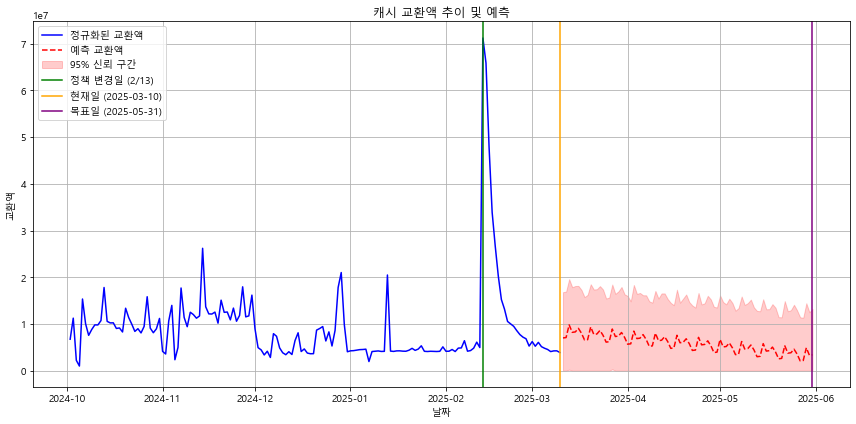

In [91]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

# 2. 정책 변경을 고려한 데이터 정규화
def normalize_data_for_policy_changes(data, policy_date):
    """
    2/13 정책 변경을 고려해 데이터 정규화
    - data: 원본 데이터
    - policy_date: 정책 변경일 (2/13)
    """
    # 정책 변경 전/후 데이터 분리
    before_policy = data[data['register_dt'] < policy_date]
    after_policy = data[data['register_dt'] >= policy_date]
    
    # 각 기간의 평균 교환액 계산 (earn_exchange 사용)
    # NaN 값 처리 추가
    avg_earn_before = before_policy['earn_exchange'].mean() if not before_policy.empty else 0
    avg_earn_after = after_policy['earn_exchange'].mean() if not after_policy.empty else 0
    
    # 조정 비율 계산 (0으로 나누기 방지)
    amount_ratio = avg_earn_after / avg_earn_before if avg_earn_before > 0 else 1
    
    print(f"정책 변경 전 평균 교환액: {avg_earn_before:.2f}")
    print(f"정책 변경 후 평균 교환액: {avg_earn_after:.2f}")
    print(f"교환액 조정 비율: {amount_ratio:.2f}")
    
    # 복사본 생성
    normalized_data = data.copy()
    
    # 'normalized_exchange_amt' 열이 없으면 생성
    if 'normalized_exchange_amt' not in normalized_data.columns:
        normalized_data['normalized_exchange_amt'] = np.nan
    
    # 정책 변경 전 데이터를 조정하여 통일된 스케일 사용 (DeprecationWarning 수정)
    normalized_data.loc[normalized_data['register_dt'] < policy_date, 'normalized_exchange_amt'] = \
        normalized_data.loc[normalized_data['register_dt'] < policy_date, 'earn_exchange'] * amount_ratio
    
    # 정책 변경 후 데이터는 그대로 사용 (DeprecationWarning 수정)
    normalized_data.loc[normalized_data['register_dt'] >= policy_date, 'normalized_exchange_amt'] = \
        normalized_data.loc[normalized_data['register_dt'] >= policy_date, 'earn_exchange']
    
    # NaN 값을 0으로 대체
    normalized_data['normalized_exchange_amt'] = normalized_data['normalized_exchange_amt'].fillna(0)
    
    return normalized_data

# 3. Prophet 모델 구성 및 예측
# def predict_with_prophet(data, prediction_days, policy_date, policy_effect=True):
#     """
#     Prophet을 사용한 예측 모델 구성
#     - data: 정규화된 데이터 (ds와 y 열이 있어야 함)
#     - prediction_days: 예측할 일수 (음수인 경우 1로 설정)
#     - policy_date: 정책 변경일
#     - policy_effect: 정책 변경 효과를 모델에 반영할지 여부
#     """
#     # 예측 일수가 음수인 경우 처리
#     prediction_days = max(1, prediction_days)
    
#     # Prophet 모델용 데이터 확인
#     if 'ds' not in data.columns or 'y' not in data.columns:
#         raise ValueError("Prophet 모델용 데이터는 'ds'와 'y' 열이 필요합니다")
    
#     # 날짜 형식 변환 확인
#     if not pd.api.types.is_datetime64_any_dtype(data['ds']):
#         data['ds'] = pd.to_datetime(data['ds'])
    
#     # NaN 값 처리
#     data = data.fillna(0)
    
#     # 음수 값이 있으면 0으로 처리 (교환액은 음수가 될 수 없음)
#     if (data['y'] < 0).any():
#         print("경고: 데이터에 음수 값이 있어 0으로 대체합니다.")
#         data['y'] = data['y'].clip(lower=0)
    
#     latest_date = data['ds'].max()
#     days_diff = (latest_date - data['ds']).dt.days
    
#     # 지수 감소 가중치 계산 (최근 데이터일수록 높은 가중치)
    
#     # Prophet 모델 구성
#     model = Prophet(
#         changepoint_prior_scale=0.01,  # 변화점 민감도 (기본값보다 낮게 설정)
#         yearly_seasonality=False,      # 데이터가 1년 미만이므로 비활성화
#         weekly_seasonality=True,       # 주간 패턴 포함
#         daily_seasonality=True,       # 일일 패턴은 데이터 부족으로 비활성화
#         growth='linear'             # 로지스틱 성장 - S자 형태의 성장 곡선
#         # growth 옵션:
#         # 'linear' - 선형 성장
#         # 'logistic' - 로지스틱 성장 (S자 곡선)
#         # 'flat' - 성장이 없는 평평한 형태
#     )
    
   

#     # 성장률이 음수가 되는 것을 방지 (교환액은 감소하는 트렌드여도 음수가 될 수 없음)
#     model.growth = 'flat' if data['y'].mean() < 1 else 'linear'
    
#     # 정책 변경 효과를 모델에 반영
#     # Prophet에서는 직접 특정 날짜를 변화점으로 지정하기 어려운 경우가 있음
#     # 대신 changepoint_prior_scale과 n_changepoints 파라미터를 조정
#     # 또는 정책 변경일에 더미 변수를 추가하는 방식 사용
    
#     if policy_effect:
#         policy_date_dt = pd.to_datetime(policy_date)
        
#         # 날짜가 데이터 범위 내에 있는지 확인
#         if (data['ds'].min() <= policy_date_dt <= data['ds'].max()):
#             # 정책 변경일을 기준으로 더미 변수 추가
#             data['policy_change'] = (data['ds'] >= policy_date_dt).astype(int)
#             # 더미 변수를 regressor로 추가
#             model.add_regressor('policy_change')
    
#     # 모델 학습
#     model.fit(data)
    
#     # 미래 데이터 프레임 생성
#     last_date = pd.to_datetime(data['ds'].max())
#     future_dates = pd.date_range(start=last_date + timedelta(days=1), 
#                                  periods=prediction_days)
    
#     future = pd.DataFrame({'ds': future_dates})
    
#     # policy_change 더미 변수가 추가된 경우, 미래 예측 데이터에도 추가
#     if 'policy_change' in data.columns:
#         policy_date_dt = pd.to_datetime(policy_date)
#         future['policy_change'] = (future['ds'] >= policy_date_dt).astype(int)
    
#     # 예측 수행
#     forecast = model.predict(future)
    
#     # 예측값이 음수인 경우 0으로 설정 (교환액은 음수가 될 수 없음)
#     forecast['yhat'] = forecast['yhat'].clip(lower=0)
#     forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
#     forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
    
#     return forecast



def predict_with_prophet(data, prediction_days, policy_date, policy_effect=True):
    """
    Prophet을 사용한 예측 모델 구성 (최근 데이터 중요도 증가)
    """
    # 최근 데이터 가중치 부여를 위한 데이터 처리
    latest_date = data['ds'].max()
    
    # 1. 전체 데이터 복사
    weighted_data = data.copy()
    
    # 2. 최근 30일 데이터 추출
    recent_mask = (latest_date - data['ds']).dt.days <= 15
    recent_data = data[recent_mask].copy()
    
    # 3. 최근 데이터를 3번 반복하여 추가 (가중치 효과)
    weighted_data = pd.concat([
        weighted_data,
        recent_data,
        recent_data,
        recent_data
    ]).reset_index(drop=True)
    
    # Prophet 모델 구성
    model = Prophet(
        changepoint_prior_scale=0.02,
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=True,
        growth='linear'
    )
    
    # 정책 변경 효과 반영
    if policy_effect:
        policy_date_dt = pd.to_datetime(policy_date)
        weighted_data['policy_change'] = (weighted_data['ds'] >= policy_date_dt).astype(int)
        model.add_regressor('policy_change')
    
    # 모델 학습
    model.fit(weighted_data)
    
    # 미래 데이터 프레임 생성
    future_dates = pd.date_range(
        start=latest_date + timedelta(days=1),
        periods=prediction_days
    )
    future = pd.DataFrame({'ds': future_dates})
    
    # policy_change 변수 추가 (정책 효과가 활성화된 경우)
    if policy_effect:
        future['policy_change'] = (future['ds'] >= policy_date_dt).astype(int)
    
    # 예측 수행
    forecast = model.predict(future)
    
    # 예측값이 음수인 경우 0으로 설정
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
    
    return forecast


# 4. 유저별 캐시 잔액 예측 함수
def predict_user_cash_balance(current_cash, forecast_exchange_amt, end_date):
    """
    유저별 캐시 잔액 예측
    - current_cash: 현재 캐시 잔액
    - forecast_exchange_amt: 예측된 교환 금액
    - end_date: 예측 종료일 (5/31)
    """
    # 예측 기간 동안의 총 교환 금액
    total_forecast_exchange = forecast_exchange_amt.sum()
    
    # 잔액 예측 (현재 잔액 - 예상 교환액)
    predicted_balance = max(0, current_cash - total_forecast_exchange)
    
    return {
        'current_cash': current_cash,
        'predicted_exchange_amount': total_forecast_exchange,
        'predicted_balance': predicted_balance,
        'exchange_ratio': total_forecast_exchange / current_cash if current_cash > 0 else 0
    }

# 5. 메인 분석 함수
def analyze_and_predict(data, policy_date, prediction_end_date, current_cash_total=None):
    """
    전체 분석 및 예측 프로세스
    - data: 분석할 데이터 (DataFrame)
    - policy_date: 정책 변경일 (2/13)
    - prediction_end_date: 예측 종료일 (5/31)
    - current_cash_total: 현재 총 캐시 잔액, None인 경우 자동 계산
    """
    # 데이터 정렬
    data = data.sort_values('register_dt')
    
    # 날짜 형식 변환 확인
    if not pd.api.types.is_datetime64_any_dtype(data['register_dt']):
        data['register_dt'] = pd.to_datetime(data['register_dt'])
    
    # 현재 캐시 총액이 제공되지 않은 경우 자동 계산
    if current_cash_total is None:
        print("각 유저의 최신 데이터 수집 중...")
        # 각 유저별로 최대 register_dt 찾기
        latest_dates = data.groupby('user_id')['register_dt'].max().reset_index()
        # 원본 데이터와 병합하여 각 유저의 최신 레코드만 추출
        latest_df = pd.merge(
            data, 
            latest_dates, 
            on=['user_id', 'register_dt'],
            how='inner'
        )
        
        # 현재 총 캐시 잔액 계산
        current_cash_total = latest_df['current_cash'].sum()
        print(f"자동 계산된 현재 총 캐시 잔액 (각 유저의 최근 접속일 기준): {current_cash_total:,.0f}")
    
    # 2. 정책 변경을 고려한 데이터 정규화
    print("데이터 정규화 중...")
    normalized_data = normalize_data_for_policy_changes(data, policy_date)
    
    # 일별 집계 (날짜별 전체 교환액 합산)
    daily_data = normalized_data.groupby('register_dt').agg(
        total_exchange=('normalized_exchange_amt', 'sum')
    ).reset_index()
    
    # 3. 전체 데이터의 최신 날짜 추출
    overall_latest_date = data['register_dt'].max()
    print(f"전체 데이터의 가장 최신 날짜: {overall_latest_date}")
    
    # 4. 예측 종료일 처리 - 날짜 형식이 아니면 변환
    if not isinstance(prediction_end_date, pd.Timestamp):
        prediction_end_date = pd.to_datetime(prediction_end_date)
    
    # 최신 날짜가 예측 종료일보다 뒤에 있는 경우, 현재 날짜로부터 3개월 후로 설정
    if overall_latest_date > prediction_end_date:
        prediction_end_date = overall_latest_date + pd.DateOffset(months=3)
        print(f"예측 종료일이 최신 데이터보다 이전이므로 {prediction_end_date.strftime('%Y-%m-%d')}로 조정합니다.")
    
    # 최신 날짜로부터 예측 종료일까지의 일수 계산
    days_to_predict = (prediction_end_date - overall_latest_date).days
    print(f"예측 기간: {days_to_predict}일 ({overall_latest_date.strftime('%Y-%m-%d')} ~ {prediction_end_date.strftime('%Y-%m-%d')})")

    # 5. Prophet 모델로 예측
    print("Prophet 모델로 예측 수행 중...")
    # Prophet에 입력할 데이터 준비 (Prophet에서는 ds와 y 열이 필요)
    prophet_input = daily_data.rename(columns={'register_dt': 'ds', 'total_exchange': 'y'})
    
    # NaN 값 처리
    prophet_input = prophet_input.fillna(0)
    
    forecast = predict_with_prophet(prophet_input, days_to_predict, policy_date)
    
    # 6. 예측된 교환 금액 총합 계산
    total_predicted_exchange = forecast['yhat'].sum()
    
    # 7. 예상 잔여 캐시 계산
    predicted_remaining_cash = max(0, current_cash_total - total_predicted_exchange)
    
    # 8. 결과 출력
    print(f"\n예측 결과 요약 (현재: {overall_latest_date.strftime('%Y-%m-%d')}, 예측 종료일: {prediction_end_date.strftime('%Y-%m-%d')})")
    print(f"예측 기간: {days_to_predict}일")
    print(f"현재 총 캐시 잔액: {current_cash_total:,.0f}")
    print(f"예상 총 교환액: {total_predicted_exchange:,.0f}")
    print(f"예상 잔여 캐시: {predicted_remaining_cash:,.0f}")
    print(f"예상 교환율: {(total_predicted_exchange/current_cash_total*100):.2f}%")
    
    # 9. 시각화
    print("예측 결과 시각화 중...")
    plt.figure(figsize=(12, 6))
    
    # 원본 데이터
    plt.plot(daily_data['register_dt'], daily_data['total_exchange'], 
             'b-', label='정규화된 교환액')
    
    # 예측 데이터
    plt.plot(forecast['ds'], forecast['yhat'], 'r--', label='예측 교환액')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                     color='r', alpha=0.2, label='95% 신뢰 구간')
    
    # 정책 변경일 표시
    plt.axvline(x=pd.to_datetime(policy_date), color='g', linestyle='-', 
                label='정책 변경일 (2/13)')
    
    # 현재일 표시
    plt.axvline(x=pd.to_datetime(overall_latest_date), color='orange', linestyle='-', 
                label=f'현재일 ({overall_latest_date.strftime("%Y-%m-%d")})')
    
    # 목표일 표시
    plt.axvline(x=pd.to_datetime(prediction_end_date), color='purple', linestyle='-', 
                label=f'목표일 ({prediction_end_date.strftime("%Y-%m-%d")})')
    
    plt.title('캐시 교환액 추이 및 예측')
    plt.xlabel('날짜')
    plt.ylabel('교환액')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig('exchange_prediction_with_policy_change.png')
    print("시각화 저장 완료: 'exchange_prediction_with_policy_change.png'")
    
    return {
        'forecast': forecast,
        'total_predicted_exchange': total_predicted_exchange,
        'predicted_remaining_cash': predicted_remaining_cash
    }

# 6. 유저별 예측 함수
def predict_per_user(data, policy_date, prediction_end_date):
    """
    각 유저별 캐시 잔액 예측
    - data: 전체 거래 데이터 (user_id, register_dt, earn_exchange, current_cash 포함)
    - policy_date: 정책 변경일 (2/13)
    - prediction_end_date: 예측 종료일 (5/31)
    """
    results = []
    
    # 날짜 형식 변환 확인
    if not pd.api.types.is_datetime64_any_dtype(data['register_dt']):
        data['register_dt'] = pd.to_datetime(data['register_dt'])
    
    # prediction_end_date 형식 변환
    prediction_end_date = pd.to_datetime(prediction_end_date)
    
    # 먼저 각 유저별 최신 데이터 한 번에 추출
    print("각 유저의 최신 데이터 추출 중...")
    latest_dates = data.groupby('user_id')['register_dt'].max().reset_index()
    latest_user_data = pd.merge(
        data,
        latest_dates,
        on=['user_id', 'register_dt'],
        how='inner'
    )
    
    # 유저별 최신 캐시 잔액 정보를 딕셔너리로 변환 (빠른 조회용)
    user_latest_info = dict(zip(
        latest_user_data['user_id'], 
        zip(latest_user_data['register_dt'], latest_user_data['current_cash'])
    ))
    
    # 고유 유저 ID 추출
    user_ids = data['user_id'].unique()
    
    print(f"유저별 예측 수행 중... (총 {len(user_ids)}명)")
    for user_id in tqdm(user_ids):
        # 해당 유저의 모든 데이터
        user_data = data[data['user_id'] == user_id]
        
        if user_id not in user_latest_info:
            print(f"사용자 {user_id}의 데이터가 없습니다. 건너뜁니다.")
            continue
        
        # 딕셔너리에서 최신 날짜와 캐시 잔액 조회 (훨씬 빠름)
        latest_date, current_cash = user_latest_info[user_id]
        
        # 최신 날짜가 예측 종료일보다 뒤에 있는 경우, 최신 날짜로부터 3개월 후로 설정
        local_prediction_end_date = prediction_end_date
        if latest_date > prediction_end_date:
            local_prediction_end_date = latest_date + pd.DateOffset(months=3)
            
        # 정규화 및 예측
        normalized_user_data = normalize_data_for_policy_changes(user_data, policy_date)
        
        # 날짜별 집계
        daily_user_data = normalized_user_data.groupby('register_dt')['normalized_exchange_amt'].sum().reset_index()
        
        # 예측 일수 계산 (최근 접속일부터 예측 종료일까지)
        days_to_predict = (local_prediction_end_date - latest_date).days
        days_to_predict = max(1, days_to_predict)  # 음수 방지
        
        # 예측 수행 (데이터가 충분한 경우만)
        if len(daily_user_data) >= 14:  # 최소 2주 데이터가 있는 경우만 예측
            # Prophet 모델용 데이터 준비
            prophet_data = daily_user_data.rename(columns={'register_dt': 'ds', 'normalized_exchange_amt': 'y'})
            
            # NaN 값 처리
            prophet_data = prophet_data.fillna(0)
            
            try:
                # 데이터가 충분하고 최소 변동성이 있는지 확인
                if prophet_data['y'].std() > 0:
                    forecast = predict_with_prophet(prophet_data, days_to_predict, policy_date)
                    
                    # 잔액 예측
                    balance_prediction = predict_user_cash_balance(current_cash, forecast['yhat'], local_prediction_end_date)
                else:
                    # 변동성이 없는 경우 단순 평균 기반 예측
                    avg_exchange = prophet_data['y'].mean()
                    forecast_yhat = pd.Series([avg_exchange] * days_to_predict)
                    balance_prediction = predict_user_cash_balance(current_cash, forecast_yhat, local_prediction_end_date)
                
                results.append({
                    'user_id': user_id,
                    'latest_activity_date': latest_date,
                    'current_cash': current_cash,
                    'predicted_exchange': balance_prediction['predicted_exchange_amount'],
                    'predicted_balance': balance_prediction['predicted_balance'],
                    'exchange_ratio': balance_prediction['exchange_ratio']
                })
            except Exception as e:
                print(f"사용자 {user_id} 예측 중 오류 발생: {e}")
        else:
            print(f"사용자 {user_id}의 데이터가 충분하지 않습니다. (데이터 수: {len(daily_user_data)})")
    
    return pd.DataFrame(results)

# 메인 실행 코드 예시
if __name__ == "__main__":
    # 파라미터 설정
    policy_date = "2025-02-13"
    prediction_end_date = "2025-05-31"
    
    # 데이터 필터링 (12/30 이후 데이터만 사용)
    filtered_df = df.query("register_dt > '2024-10-01'")
    
    # 날짜 형식 변환 확인
    if not pd.api.types.is_datetime64_any_dtype(filtered_df['register_dt']):
        filtered_df['register_dt'] = pd.to_datetime(filtered_df['register_dt'])
    
    # 정확한 현재 캐시 총액 계산
    # 각 유저별 가장 최근 접속일의 데이터 한 번에 찾기 (group by 활용)
    print("각 유저의 최신 데이터 수집 중...")
    # 각 유저별로 최대 register_dt 찾기
    latest_dates = filtered_df.groupby('user_id')['register_dt'].max().reset_index()
    # 원본 데이터와 병합하여 각 유저의 최신 레코드만 추출
    latest_df = pd.merge(
        filtered_df, 
        latest_dates, 
        on=['user_id', 'register_dt'],
        how='inner'
    )
    
    # 현재 총 캐시 잔액 계산
    current_cash_total = latest_df['current_cash'].sum()
    
    print(f"계산된 현재 총 캐시 잔액 (각 유저의 최근 접속일 기준): {current_cash_total:,.0f}")
    
    # 분석 및 예측 실행
    results = analyze_and_predict(filtered_df, policy_date, prediction_end_date, current_cash_total)
    
    # 예측 결과 활용
    print("\n일별 예측 결과:")
    print(results['forecast'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
    
    # 유저별 예측 (선택적 실행)
    # user_predictions = predict_per_user(filtered_df, policy_date, prediction_end_date)
    # print("\n유저별 예측 결과 (상위 5명):")
    # print(user_predictions.head())

In [92]:
pd.set_option('display.max_rows', 100)
# 과학적 표기법 없이 결과 표시
pd.options.display.float_format = '{:.0f}'.format
results['forecast'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2025-03-11,7018235,0,16820861
1,2025-03-12,7103540,0,16937193
2,2025-03-13,9816999,235842,19610802
3,2025-03-14,8220435,0,17885352
4,2025-03-15,8309822,0,18135654
5,2025-03-16,9074058,0,18156391
6,2025-03-17,8027481,0,17301350
7,2025-03-18,6572312,0,15756340
8,2025-03-19,6657617,0,16256115
9,2025-03-20,9371076,0,18513491


각 유저의 최신 데이터 수집 중...
계산된 현재 총 캐시 잔액 (각 유저의 최근 접속일 기준): 1,164,139,405
1단계: 전체 데이터에 대한 Prophet 모델 예측 수행 중...
데이터 정규화 중...
정책 변경 전 평균 교환액: 16.04
정책 변경 후 평균 교환액: 218.87
교환액 조정 비율: 13.64
전체 데이터의 가장 최신 날짜: 2025-03-09 00:00:00
예측 기간: 83일 (2025-03-09 ~ 2025-05-31)
Prophet 모델로 예측 수행 중...


17:06:06 - cmdstanpy - INFO - Chain [1] start processing
17:06:09 - cmdstanpy - INFO - Chain [1] done processing



예측 결과 요약 (현재: 2025-03-09, 예측 종료일: 2025-05-31)
예측 기간: 83일
현재 총 캐시 잔액: 1,164,139,405
예상 총 교환액: 278,945,101
예상 잔여 캐시: 885,194,304
예상 교환율: 23.96%
예측 결과 시각화 중...
시각화 저장 완료: 'exchange_prediction_with_policy_change.png'

2단계: 세그먼트 기반 사용자별 예측 수행 중...
사용자별 최신 데이터 추출 중...
사용자 교환 패턴 집계 중...
재산 규모 분위수: 25%=283, 50%=1868, 75%=5806
활동성 분위수 (일 단위): 25%=1, 50%=20, 75%=37
세그먼트 기반 교환액 예측 계산 중...


100%|██████████| 268682/268682 [00:06<00:00, 38737.92it/s]



세그먼트 기반 예측 결과 요약:
총 사용자 수: 268,682명
총 현재 캐시 잔액: 1,164,139,405
총 예상 교환액: 317,575,629
총 예상 잔여 캐시: 846,563,776
전체 예상 교환율: 27.28%

세그먼트별 예측 결과:
세그먼트 1: 57,425명, 평균 재산 476, 예상 교환율 5.00%
세그먼트 2: 53,450명, 평균 재산 2,859, 예상 교환율 9.96%
세그먼트 3: 50,669명, 평균 재산 3,484, 예상 교환율 14.95%
세그먼트 4: 57,791명, 평균 재산 5,269, 예상 교환율 24.78%
세그먼트 5: 49,347명, 평균 재산 10,193, 예상 교환율 39.59%

3단계: 하이브리드 결과 계산 (Prophet 70%, 세그먼트 30%)...

최종 하이브리드 예측 결과 요약:
Prophet 예측 교환액: 278,945,101
세그먼트 예측 교환액: 317,575,629
하이브리드 예측 교환액: 290,534,260
예상 잔여 캐시: 873,605,145
전체 예상 교환율: 24.96%

하이브리드 모델 세그먼트별 결과:
세그먼트 1: 57,425명, 평균 재산 476, 예상 교환액 1,250,078, 예상 교환율 4.57%
세그먼트 2: 53,450명, 평균 재산 2,859, 예상 교환액 13,927,104, 예상 교환율 9.11%
세그먼트 3: 50,669명, 평균 재산 3,484, 예상 교환액 24,141,253, 예상 교환율 13.68%
세그먼트 4: 57,791명, 평균 재산 5,269, 예상 교환액 69,025,658, 예상 교환율 22.67%
세그먼트 5: 49,347명, 평균 재산 10,193, 예상 교환액 182,190,166, 예상 교환율 36.22%

예측 결과 시각화 중...
정책 변경 전 평균 교환액: 16.04
정책 변경 후 평균 교환액: 218.87
교환액 조정 비율: 13.64
시각화 저장 완료: 'hybrid_prediction_results.png'

유저별 

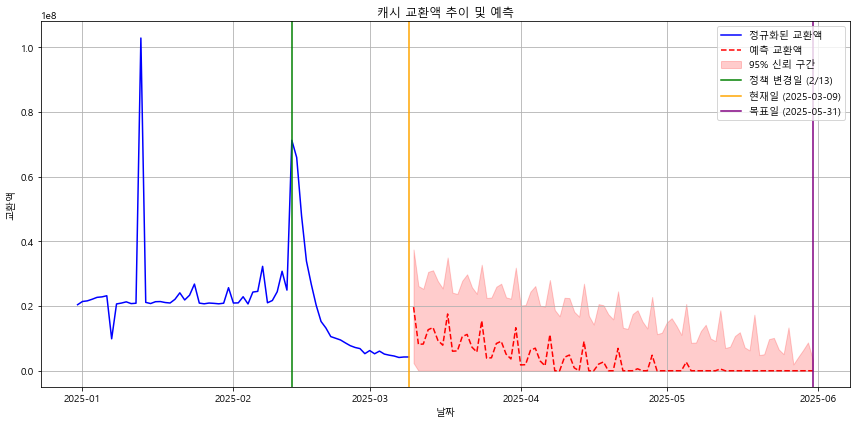

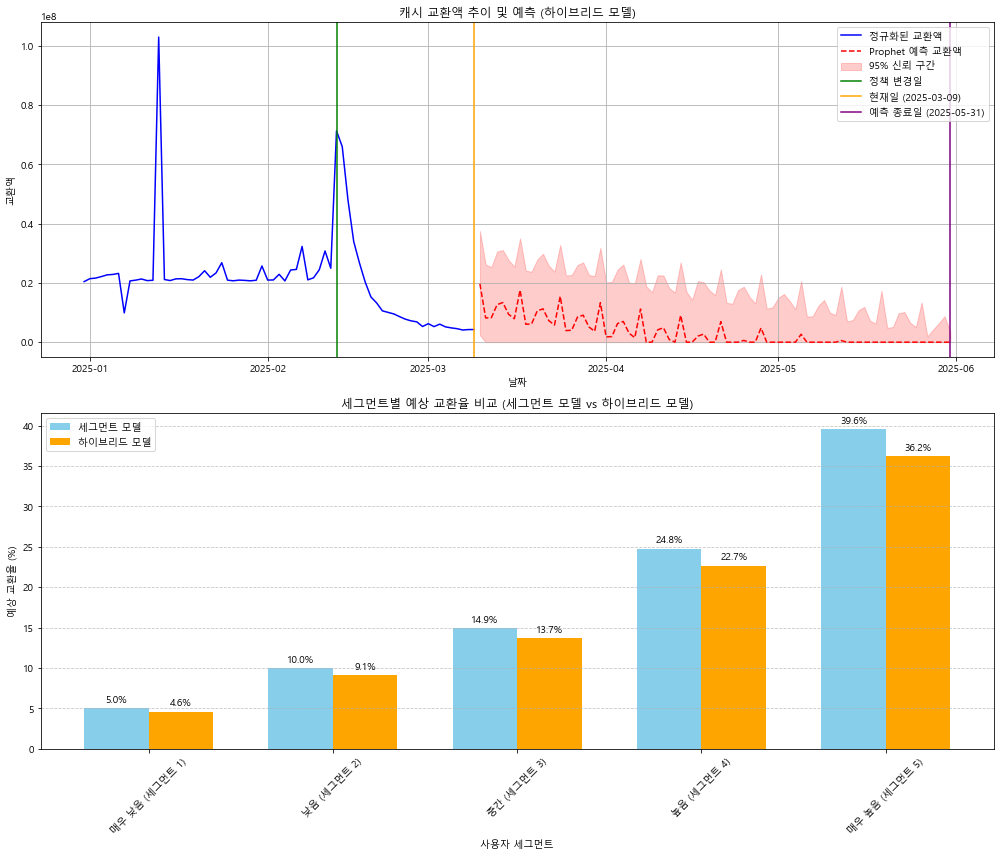

In [63]:
# 하이브리드 예측 접근법 구현 (Prophet 70%, 세그먼트 30%)

def hybrid_prediction_approach(data, policy_date, prediction_end_date, current_cash_total=None):
    """
    하이브리드 예측 접근법:
    1. 전체 데이터에 대해 Prophet 모델 1회 실행 (시계열 패턴 포착)
    2. 세그먼트 기반 사용자별 예측 (Prophet 사용하지 않음)
    3. Prophet 결과 70%, 세그먼트 예측 30% 가중치 적용
    
    Parameters:
    -----------
    data : DataFrame
        분석할 데이터 (user_id, register_dt, earn_exchange, current_cash 포함)
    policy_date : str
        정책 변경일 (YYYY-MM-DD 형식)
    prediction_end_date : str
        예측 종료일 (YYYY-MM-DD 형식)
    current_cash_total : float, optional
        현재 총 캐시 잔액, None인 경우 자동 계산
        
    Returns:
    --------
    dict
        'forecast': Prophet 예측 결과
        'total_predicted_exchange': 하이브리드 방식 총 예측 교환액
        'predicted_remaining_cash': 예상 잔여 캐시
        'user_predictions': 사용자별 예측 결과 (DataFrame)
    """
    # 1. 기본 전체 예측 (기존 Prophet 사용)
    print("1단계: 전체 데이터에 대한 Prophet 모델 예측 수행 중...")
    prophet_results = analyze_and_predict(data, policy_date, prediction_end_date, current_cash_total, run_user_predictions=False)
    global_forecast = prophet_results['forecast']
    global_predicted_exchange = prophet_results['total_predicted_exchange']
    
    # 2. 세그먼트 기반 사용자별 예측
    print("\n2단계: 세그먼트 기반 사용자별 예측 수행 중...")
    segment_results = optimized_predict_per_user(data, policy_date, prediction_end_date)
    segment_predicted_exchange = segment_results['predicted_exchange'].sum()
    
    # 3. 두 모델의 결과 조정 (가중 평균 - Prophet 70%, 세그먼트 30%)
    prophet_weight = 0.7  # 70% 가중치
    segment_weight = 0.3  # 30% 가중치
    
    print(f"\n3단계: 하이브리드 결과 계산 (Prophet {prophet_weight*100:.0f}%, 세그먼트 {segment_weight*100:.0f}%)...")
    combined_predicted_exchange = (global_predicted_exchange * prophet_weight + 
                                  segment_predicted_exchange * segment_weight)
    
    # 4. 세그먼트별 결과를 전체 하이브리드 예측에 맞게 조정
    adjustment_ratio = combined_predicted_exchange / segment_predicted_exchange if segment_predicted_exchange > 0 else 1
    segment_results['adjusted_predicted_exchange'] = segment_results['predicted_exchange'] * adjustment_ratio
    segment_results['adjusted_predicted_balance'] = segment_results['current_cash'] - segment_results['adjusted_predicted_exchange']
    segment_results['adjusted_exchange_ratio'] = segment_results['adjusted_predicted_exchange'] / segment_results['current_cash']
    
    # 조정된 사용자별 결과가 현재 캐시를 초과하지 않도록 보정
    segment_results['adjusted_predicted_exchange'] = segment_results.apply(
        lambda row: min(row['adjusted_predicted_exchange'], row['current_cash']), axis=1
    )
    segment_results['adjusted_predicted_balance'] = segment_results['current_cash'] - segment_results['adjusted_predicted_exchange']
    
    # 결과 요약
    total_current_cash = segment_results['current_cash'].sum()
    total_adjusted_exchange = segment_results['adjusted_predicted_exchange'].sum()
    total_adjusted_balance = segment_results['adjusted_predicted_balance'].sum()
    overall_adjusted_ratio = total_adjusted_exchange / total_current_cash if total_current_cash > 0 else 0
    
    # 최종 결과가 Prophet와 세그먼트 모델 예측 범위 내에 있는지 확인
    print("\n최종 하이브리드 예측 결과 요약:")
    print(f"Prophet 예측 교환액: {global_predicted_exchange:,.0f}")
    print(f"세그먼트 예측 교환액: {segment_predicted_exchange:,.0f}")
    print(f"하이브리드 예측 교환액: {total_adjusted_exchange:,.0f}")
    print(f"예상 잔여 캐시: {total_adjusted_balance:,.0f}")
    print(f"전체 예상 교환율: {overall_adjusted_ratio*100:.2f}%")
    
    # 5. 세그먼트별 결과 분석
    print("\n하이브리드 모델 세그먼트별 결과:")
    for segment in range(1, 6):  # 5개 세그먼트
        segment_df = segment_results[segment_results['combined_segment'] == segment]
        if not segment_df.empty:
            seg_total_cash = segment_df['current_cash'].sum()
            seg_total_exchange = segment_df['adjusted_predicted_exchange'].sum()
            seg_ratio = seg_total_exchange / seg_total_cash if seg_total_cash > 0 else 0
            
            print(f"세그먼트 {segment}: {len(segment_df):,}명, "
                  f"평균 재산 {segment_df['current_cash'].mean():,.0f}, "
                  f"예상 교환액 {seg_total_exchange:,.0f}, "
                  f"예상 교환율 {seg_ratio*100:.2f}%")
    
    return {
        'forecast': global_forecast,
        'total_predicted_exchange': total_adjusted_exchange,
        'predicted_remaining_cash': total_adjusted_balance,
        'user_predictions': segment_results,
        'prophet_predicted_exchange': global_predicted_exchange,
        'segment_predicted_exchange': segment_predicted_exchange
    }


# 세그먼트 기반 사용자별 예측 함수 (Prophet 없이)
def optimized_predict_per_user(data, policy_date, prediction_end_date):
    """
    클러스터링 기반 사용자 예측 - 개별 Prophet 예측 대신 그룹 기반 접근법 사용
    """
    # 데이터 준비
    data = data.copy()
    if not pd.api.types.is_datetime64_any_dtype(data['register_dt']):
        data['register_dt'] = pd.to_datetime(data['register_dt'])
    
    prediction_end_date = pd.to_datetime(prediction_end_date)
    global_latest_date = data['register_dt'].max()
    
    # 사용자별 최신 데이터 추출
    print("사용자별 최신 데이터 추출 중...")
    latest_dates = data.groupby('user_id')['register_dt'].max().reset_index()
    latest_user_data = pd.merge(data, latest_dates, on=['user_id', 'register_dt'], how='inner')
    
    # 활동성 계산 (최신 접속일로부터의 일수)
    latest_user_data['days_since_last_visit'] = (global_latest_date - latest_user_data['register_dt']).dt.days
    
    # 사용자 특성 계산 (교환 패턴)
    print("사용자 교환 패턴 집계 중...")
    user_exchange_patterns = data.groupby('user_id').agg({
        'earn_exchange': ['mean', 'std', 'count', 'sum']
    })
    user_exchange_patterns.columns = ['avg_exchange', 'std_exchange', 'exchange_count', 'total_exchange']
    user_exchange_patterns = user_exchange_patterns.reset_index()
    
    # 사용자별 데이터 병합
    user_data = pd.merge(latest_user_data[['user_id', 'current_cash', 'days_since_last_visit']], 
                          user_exchange_patterns, on='user_id', how='left')
    
    # NaN 값 처리
    user_data = user_data.fillna({
        'avg_exchange': 0,
        'std_exchange': 0,
        'exchange_count': 0,
        'total_exchange': 0
    })
    
    # 1. 사용자 세그먼트 정의 (활동성 및 재산 규모 기준)
    cash_quantiles = user_data['current_cash'].quantile([0.25, 0.5, 0.75]).tolist()
    activity_quantiles = user_data['days_since_last_visit'].quantile([0.25, 0.5, 0.75]).tolist()
    
    print(f"재산 규모 분위수: 25%={cash_quantiles[0]:.0f}, 50%={cash_quantiles[1]:.0f}, 75%={cash_quantiles[2]:.0f}")
    print(f"활동성 분위수 (일 단위): 25%={activity_quantiles[0]:.0f}, 50%={activity_quantiles[1]:.0f}, 75%={activity_quantiles[2]:.0f}")
    
    # 2. 세그먼트 할당
    # 재산 규모 세그먼트
    conditions = [
        (user_data['current_cash'] <= cash_quantiles[0]),
        (user_data['current_cash'] > cash_quantiles[0]) & (user_data['current_cash'] <= cash_quantiles[1]),
        (user_data['current_cash'] > cash_quantiles[1]) & (user_data['current_cash'] <= cash_quantiles[2]),
        (user_data['current_cash'] > cash_quantiles[2])
    ]
    values = [1, 2, 3, 4]  # 하위 25%, 25-50%, 50-75%, 상위 25%
    user_data['cash_segment'] = np.select(conditions, values, default=0)
    
    # 활동성 세그먼트
    conditions = [
        (user_data['days_since_last_visit'] < activity_quantiles[0]),
        (user_data['days_since_last_visit'] >= activity_quantiles[0]) & (user_data['days_since_last_visit'] < activity_quantiles[1]),
        (user_data['days_since_last_visit'] >= activity_quantiles[1]) & (user_data['days_since_last_visit'] < activity_quantiles[2]),
        (user_data['days_since_last_visit'] >= activity_quantiles[2])
    ]
    values = [4, 3, 2, 1]  # 높은 활동성(4), 중상 활동성(3), 중하 활동성(2), 낮은 활동성(1)
    user_data['activity_segment'] = np.select(conditions, values, default=0)
    
    # 교환 패턴 세그먼트 (교환 빈도 기준)
    exchange_count_quantiles = user_data['exchange_count'].quantile([0.25, 0.5, 0.75]).tolist()
    conditions = [
        (user_data['exchange_count'] <= exchange_count_quantiles[0]),
        (user_data['exchange_count'] > exchange_count_quantiles[0]) & (user_data['exchange_count'] <= exchange_count_quantiles[1]),
        (user_data['exchange_count'] > exchange_count_quantiles[1]) & (user_data['exchange_count'] <= exchange_count_quantiles[2]),
        (user_data['exchange_count'] > exchange_count_quantiles[2])
    ]
    values = [1, 2, 3, 4]  # 낮은 교환 빈도(1) ~ 높은 교환 빈도(4)
    user_data['exchange_segment'] = np.select(conditions, values, default=0)
    
    # 3. 복합 세그먼트 생성 (재산, 활동성, 교환 패턴 결합)
    # 가중치 설정: 재산(1.5) > 활동성(1.2) > 교환 패턴(1.0)
    user_data['weighted_score'] = (user_data['cash_segment'] * 1.5 + 
                                   user_data['activity_segment'] * 1.2 + 
                                   user_data['exchange_segment'] * 1.0)
    
    # 복합 점수 기반 세그먼트 할당 (5개 세그먼트)
    segment_quantiles = user_data['weighted_score'].quantile([0.2, 0.4, 0.6, 0.8]).tolist()
    conditions = [
        (user_data['weighted_score'] <= segment_quantiles[0]),
        (user_data['weighted_score'] > segment_quantiles[0]) & (user_data['weighted_score'] <= segment_quantiles[1]),
        (user_data['weighted_score'] > segment_quantiles[1]) & (user_data['weighted_score'] <= segment_quantiles[2]),
        (user_data['weighted_score'] > segment_quantiles[2]) & (user_data['weighted_score'] <= segment_quantiles[3]),
        (user_data['weighted_score'] > segment_quantiles[3])
    ]
    values = [1, 2, 3, 4, 5]  # 1(매우 낮음) ~ 5(매우 높음)
    user_data['combined_segment'] = np.select(conditions, values, default=3)
    
    # 4. 세그먼트별 교환 비율 설정 (기대 교환율)
    # 세그먼트 1: 5%, 세그먼트 2: 10%, 세그먼트 3: 15%, 세그먼트 4: 25%, 세그먼트 5: 40%
    exchange_ratios = {1: 0.05, 2: 0.10, 3: 0.15, 4: 0.25, 5: 0.40}
    
    # 예측 기간 계산 (일 단위)
    days_to_predict = (prediction_end_date - global_latest_date).days
    days_to_predict = max(1, days_to_predict)  # 음수 방지
    
    # Prophet 모델 대신 세그먼트 기반 기대 교환율 적용
    print("세그먼트 기반 교환액 예측 계산 중...")
    results = []
    
    for _, row in tqdm(user_data.iterrows(), total=len(user_data)):
        user_id = row['user_id']
        current_cash = row['current_cash']
        segment = row['combined_segment']
        cash_segment = row['cash_segment']
        activity_segment = row['activity_segment']
        
        # 세그먼트별 기대 교환율
        expected_exchange_ratio = exchange_ratios[segment]
        
        # 개인별 조정 (일부 랜덤성 추가 - 세그먼트 내 변동성)
        variation = np.random.uniform(0.85, 1.15)  # ±15% 변동
        adjusted_ratio = expected_exchange_ratio * variation
        
        # 재산 규모에 따른 추가 조정 (큰 금액일수록 보수적으로)
        if current_cash > cash_quantiles[2] * 10:  # 상위 25% 10배 이상
            adjusted_ratio *= 0.7  # 30% 감소
        elif current_cash > cash_quantiles[2] * 5:  # 상위 25% 5배 이상
            adjusted_ratio *= 0.8  # 20% 감소
        
        # 예상 교환액 계산
        predicted_exchange = current_cash * adjusted_ratio
        predicted_balance = current_cash - predicted_exchange
        
        results.append({
            'user_id': user_id,
            'current_cash': current_cash,
            'combined_segment': segment,
            'cash_segment': cash_segment,
            'activity_segment': activity_segment,
            'expected_exchange_ratio': expected_exchange_ratio,
            'adjusted_ratio': adjusted_ratio,
            'predicted_exchange': predicted_exchange,
            'predicted_balance': predicted_balance,
            'exchange_ratio': adjusted_ratio  # 교환율로 저장
        })
    
    result_df = pd.DataFrame(results)
    
    # 결과 요약 출력
    if not result_df.empty:
        total_current_cash = result_df['current_cash'].sum()
        total_predicted_exchange = result_df['predicted_exchange'].sum()
        total_predicted_balance = result_df['predicted_balance'].sum()
        overall_exchange_ratio = total_predicted_exchange / total_current_cash if total_current_cash > 0 else 0
        
        print("\n세그먼트 기반 예측 결과 요약:")
        print(f"총 사용자 수: {len(result_df):,}명")
        print(f"총 현재 캐시 잔액: {total_current_cash:,.0f}")
        print(f"총 예상 교환액: {total_predicted_exchange:,.0f}")
        print(f"총 예상 잔여 캐시: {total_predicted_balance:,.0f}")
        print(f"전체 예상 교환율: {overall_exchange_ratio*100:.2f}%")
        
        # 세그먼트별 예측 요약
        print("\n세그먼트별 예측 결과:")
        for segment in range(1, 6):
            segment_df = result_df[result_df['combined_segment'] == segment]
            if not segment_df.empty:
                seg_total_cash = segment_df['current_cash'].sum()
                seg_total_exchange = segment_df['predicted_exchange'].sum()
                seg_ratio = seg_total_exchange / seg_total_cash if seg_total_cash > 0 else 0
                print(f"세그먼트 {segment}: {len(segment_df):,}명, "
                      f"평균 재산 {segment_df['current_cash'].mean():,.0f}, "
                      f"예상 교환율 {seg_ratio*100:.2f}%")
    
    return result_df


# 메인 실행 코드에 하이브리드 접근법 추가
def main(data, policy_date, prediction_end_date, current_cash_total=None):
    """
    메인 실행 함수
    """
    if not pd.api.types.is_datetime64_any_dtype(data['register_dt']):
        data['register_dt'] = pd.to_datetime(data['register_dt'])
    
    # 필요한 경우 current_cash_total 계산
    if current_cash_total is None:
        print("각 유저의 최신 데이터 수집 중...")
        latest_dates = data.groupby('user_id')['register_dt'].max().reset_index()
        latest_df = pd.merge(data, latest_dates, on=['user_id', 'register_dt'], how='inner')
        current_cash_total = latest_df['current_cash'].sum()
        print(f"계산된 현재 총 캐시 잔액 (각 유저의 최근 접속일 기준): {current_cash_total:,.0f}")
    
    # 하이브리드 예측 수행 (Prophet 70%, 세그먼트 30%)
    results = hybrid_prediction_approach(data, policy_date, prediction_end_date, current_cash_total)
    
    # 예측 결과 시각화
    print("\n예측 결과 시각화 중...")
    visualize_hybrid_results(data, results, policy_date, prediction_end_date)
    
    # 유저별 예측 결과 저장
    user_pred_file = 'user_predictions_hybrid.csv'
    results['user_predictions'].to_csv(user_pred_file, index=False)
    print(f"\n유저별 예측 결과가 {user_pred_file}에 저장되었습니다.")
    
    # 상위 10명 사용자 출력
    print("\n교환액 상위 10명 사용자:")
    top_users = results['user_predictions'].sort_values('adjusted_predicted_exchange', ascending=False).head(10)
    print(top_users[['user_id', 'current_cash', 'adjusted_predicted_exchange', 'adjusted_exchange_ratio']])
    
    return results


# 하이브리드 예측 결과 시각화 함수
def visualize_hybrid_results(data, results, policy_date, prediction_end_date):
    """
    하이브리드 예측 접근법 결과 시각화
    """
    # 전체 데이터에서 최신 날짜 및 정규화된 데이터 준비
    overall_latest_date = data['register_dt'].max()
    normalized_data = normalize_data_for_policy_changes(data, policy_date)
    daily_data = normalized_data.groupby('register_dt').agg(
        total_exchange=('normalized_exchange_amt', 'sum')
    ).reset_index()
    
    # Prophet 예측 결과
    global_forecast = results['forecast']
    
    # 시각화 설정
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # 1. 첫 번째 그래프: 교환액 시계열 및 예측
    ax1 = axes[0]
    
    # 원본 데이터
    ax1.plot(daily_data['register_dt'], daily_data['total_exchange'], 
             'b-', label='정규화된 교환액')
    
    # 예측 데이터
    ax1.plot(global_forecast['ds'], global_forecast['yhat'], 'r--', label='Prophet 예측 교환액')
    ax1.fill_between(global_forecast['ds'], global_forecast['yhat_lower'], global_forecast['yhat_upper'], 
                     color='r', alpha=0.2, label='95% 신뢰 구간')
    
    # 주요 날짜 표시
    ax1.axvline(x=pd.to_datetime(policy_date), color='g', linestyle='-', 
                label='정책 변경일')
    ax1.axvline(x=pd.to_datetime(overall_latest_date), color='orange', linestyle='-', 
                label=f'현재일 ({overall_latest_date.strftime("%Y-%m-%d")})')
    ax1.axvline(x=pd.to_datetime(prediction_end_date), color='purple', linestyle='-', 
                label=f'예측 종료일 ({pd.to_datetime(prediction_end_date).strftime("%Y-%m-%d")})')
    
    # 그래프 설정
    ax1.set_title('캐시 교환액 추이 및 예측 (하이브리드 모델)')
    ax1.set_xlabel('날짜')
    ax1.set_ylabel('교환액')
    ax1.legend()
    ax1.grid(True)
    
    # 2. 두 번째 그래프: 세그먼트별 교환율
    ax2 = axes[1]
    
    # 사용자 예측 데이터
    user_predictions = results['user_predictions']
    
    # 세그먼트별 통계
    segment_stats = user_predictions.groupby('combined_segment').agg({
        'current_cash': 'sum',
        'predicted_exchange': 'sum',
        'adjusted_predicted_exchange': 'sum'
    })
    
    # 교환율 계산
    segment_stats['segment_exchange_ratio'] = segment_stats['predicted_exchange'] / segment_stats['current_cash'] * 100
    segment_stats['hybrid_exchange_ratio'] = segment_stats['adjusted_predicted_exchange'] / segment_stats['current_cash'] * 100
    
    # 세그먼트 레이블
    segment_labels = {
        1: '매우 낮음 (세그먼트 1)',
        2: '낮음 (세그먼트 2)',
        3: '중간 (세그먼트 3)',
        4: '높음 (세그먼트 4)',
        5: '매우 높음 (세그먼트 5)'
    }
    
    # 새로운 인덱스 생성
    segment_stats.index = [segment_labels[i] for i in segment_stats.index]
    
    # 바 차트 생성 - 세그먼트 모델과 하이브리드 모델 비교
    width = 0.35
    x = np.arange(len(segment_stats.index))
    
    ax2.bar(x - width/2, segment_stats['segment_exchange_ratio'], width, label='세그먼트 모델', color='skyblue')
    ax2.bar(x + width/2, segment_stats['hybrid_exchange_ratio'], width, label='하이브리드 모델', color='orange')
    
    # 그래프 설정
    ax2.set_title('세그먼트별 예상 교환율 비교 (세그먼트 모델 vs 하이브리드 모델)')
    ax2.set_xlabel('사용자 세그먼트')
    ax2.set_ylabel('예상 교환율 (%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(segment_stats.index, rotation=45)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 각 막대 위에 값 표시
    for i, v in enumerate(segment_stats['segment_exchange_ratio']):
        ax2.text(i - width/2, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    for i, v in enumerate(segment_stats['hybrid_exchange_ratio']):
        ax2.text(i + width/2, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('hybrid_prediction_results.png')
    print("시각화 저장 완료: 'hybrid_prediction_results.png'")

# 기존 파일의 끝부분에 다음 코드 추가
if __name__ == "__main__":
    # 파라미터 설정
    policy_date = "2025-02-13"
    prediction_end_date = "2025-05-31"
    
    # 데이터 필터링 (12/30 이후 데이터만 사용)
    filtered_df = df.query("register_dt > '2024-12-30'")
    
    # 날짜 형식 변환 확인
    if not pd.api.types.is_datetime64_any_dtype(filtered_df['register_dt']):
        filtered_df['register_dt'] = pd.to_datetime(filtered_df['register_dt'])
    
    # 하이브리드 예측 실행
    results = main(filtered_df, policy_date, prediction_end_date)

각 유저의 최신 데이터 수집 중...
계산된 현재 총 캐시 잔액 (각 유저의 최근 접속일 기준): 1,164,139,405
미방문일 데이터 계산 중...

계산된 미방문일 구간별 데이터:
week_bucket,current_cash,user_id
0-6일,522710473,106218
7-13일,52230792,17440
14-20일,41264752,12168
21-27일,47271128,12722
28-34일,178824784,30581
35-41일,171223355,36130
42-48일,45688802,16292
49-55일,28246483,10527
56-62일,31005106,10921
63-69일,45673730,15683
1단계: 전체 데이터에 대한 Prophet 모델 예측 수행 중...
Prophet 모델 학습 중...


17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:36 - cmdstanpy - INFO - Chain [1] done processing



Prophet 모델 예측 결과:
예측 시작일: 2025-03-09
예측 종료일: 2025-05-31
예측 기간: 83일
총 예상 교환액: 32,583,302,286
현재 총 캐시 잔액: 1,164,139,405
예상 잔여 캐시: -31,419,162,881
예상 교환 비율: 2798.92%

2단계: 미방문일 데이터가 통합된 세그먼트 기반 사용자별 예측 수행 중...
사용자별 최신 데이터 추출 중...
사용자 교환 패턴 집계 중...
재산 규모 분위수: 25%=283, 50%=1868, 75%=5806
활동성 분위수 (일 단위): 25%=1, 50%=20, 75%=37
미방문일 세그먼트 데이터 통합 중...

미방문일 데이터 기반 조정된 세그먼트별 교환 비율:
세그먼트 1: 4.8% (기존: 5.0%)
세그먼트 2: 10.0% (기존: 10.0%)
세그먼트 3: 15.0% (기존: 15.0%)
세그먼트 4: 25.0% (기존: 25.0%)
세그먼트 5: 45.3% (기존: 40.0%)
세그먼트 기반 교환액 예측 계산 중...


100%|██████████| 268682/268682 [00:07<00:00, 35729.02it/s]



세그먼트 기반 예측 결과 요약:
총 사용자 수: 268,682명
총 현재 캐시 잔액: 1,164,139,405
총 예상 교환액: 322,719,615
총 예상 잔여 캐시: 841,419,790
전체 예상 교환율: 27.72%

세그먼트별 예측 결과:
세그먼트 1: 54,783명, 평균 재산 726, 예상 교환율 3.63%
세그먼트 2: 53,842명, 평균 재산 3,091, 예상 교환율 7.91%
세그먼트 3: 61,281명, 평균 재산 3,157, 예상 교환율 12.35%
세그먼트 4: 51,400명, 평균 재산 5,166, 예상 교환율 22.62%
세그먼트 5: 47,376명, 평균 재산 10,532, 예상 교환율 44.93%

미방문일 그룹별 예측 결과:
0-7일: 106,218명, 평균 재산 4,921, 예상 교환율 42.49%
7-14일: 17,440명, 평균 재산 2,995, 예상 교환율 36.39%
14-21일: 12,168명, 평균 재산 3,391, 예상 교환율 23.18%
21-28일: 12,722명, 평균 재산 3,716, 예상 교환율 22.05%
28-35일: 30,581명, 평균 재산 5,848, 예상 교환율 18.26%
35-63일: 73,870명, 평균 재산 3,739, 예상 교환율 9.59%
63-91일: 15,683명, 평균 재산 2,912, 예상 교환율 5.47%

3단계: 하이브리드 결과 계산 (Prophet 70%, 세그먼트 30%)...

최종 하이브리드 예측 결과 요약:
Prophet 예측 교환액: 32,583,302,286
세그먼트 예측 교환액: 322,719,615
하이브리드 예측 교환액: 1,164,139,405
예상 잔여 캐시: 0
전체 예상 교환율: 100.00%

하이브리드 모델 세그먼트별 결과:
세그먼트 1: 54,783명, 평균 재산 726, 예상 교환액 39,784,334, 예상 교환율 100.00%
세그먼트 2: 53,842명, 평균 재산 3,091, 예상 교환액 166,449,687, 예상 교환율 10

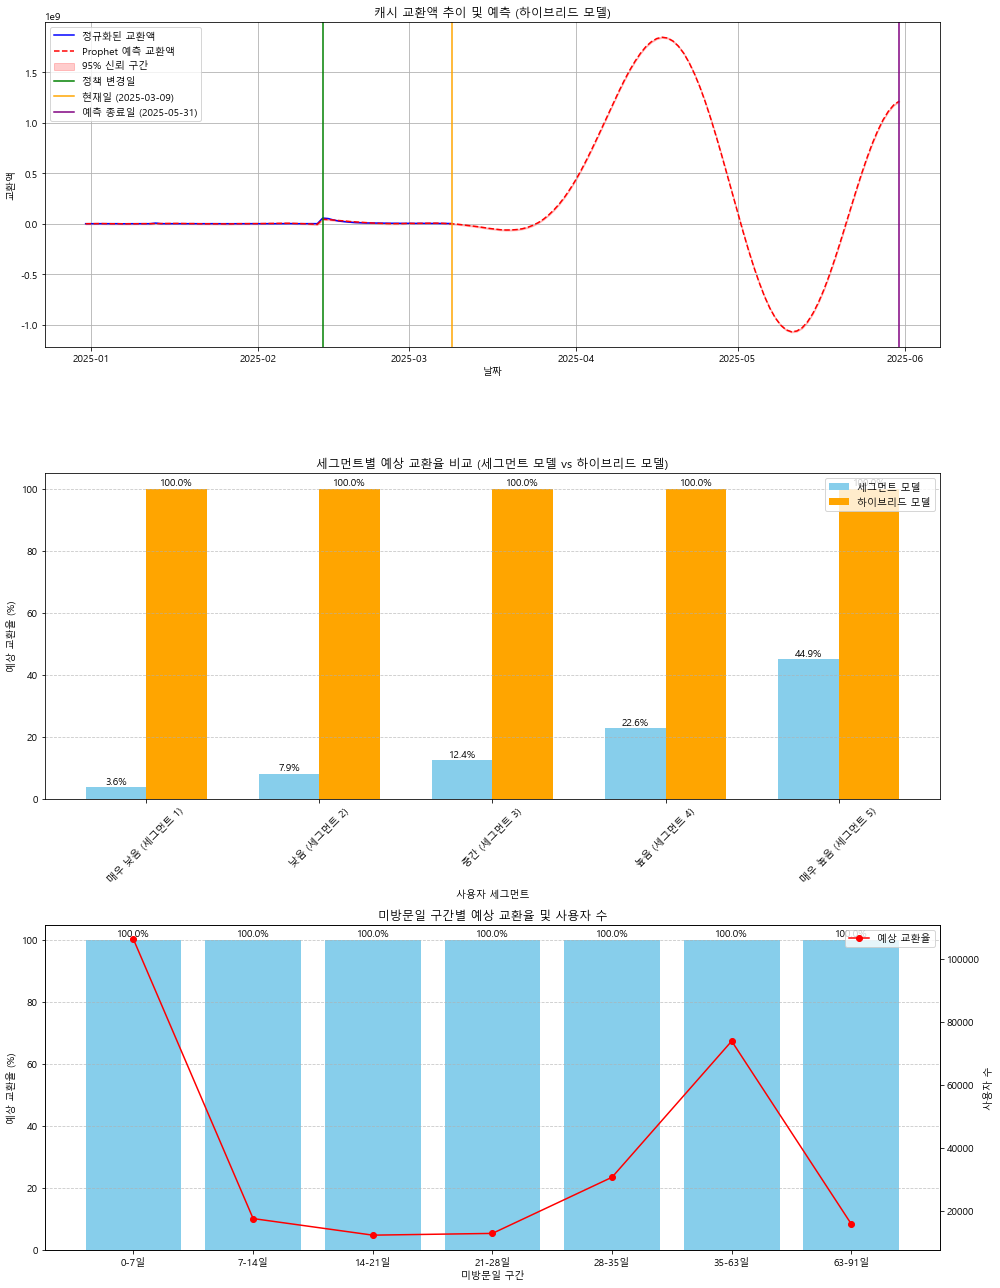

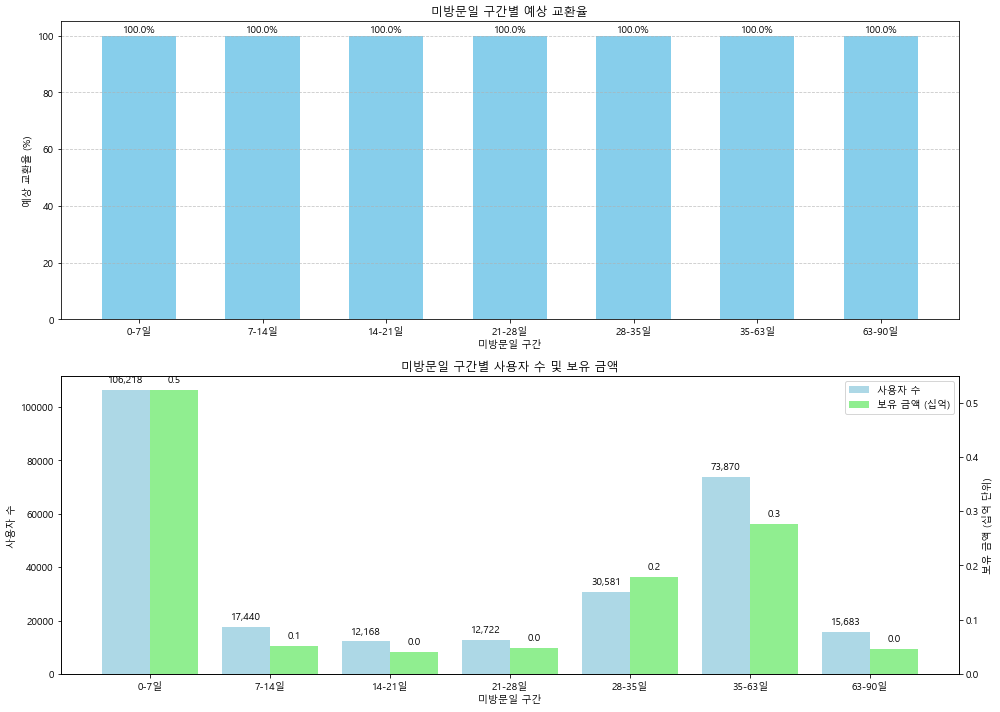

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from prophet import Prophet

# 미방문일 데이터 처리 함수
def parse_week_bucket_data(week_data_str):
    """미방문일 주별 데이터를 파싱하여 DataFrame으로 변환"""
    lines = week_data_str.strip().split('\n')
    data = []
    
    for line in lines[1:]:  # 헤더 제외
        week_bucket, current_cash, user_count = line.split(',')
        
        # 미방문일 범위에서 중간값 계산
        day_range = week_bucket.replace('일', '')
        min_day, max_day = map(int, day_range.split('-'))
        avg_days_since_visit = (min_day + max_day) // 2
        
        data.append({
            'week_bucket': week_bucket,
            'current_cash': int(current_cash),
            'user_count': int(user_count),
            'days_since_last_visit': avg_days_since_visit
        })
    
    return pd.DataFrame(data)

# 정책 변경에 따른 데이터 정규화 함수
def normalize_data_for_policy_changes(data, policy_date):
    """
    정책 변경 전후의 데이터를 정규화하는 함수
    """
    data = data.copy()
    
    # 날짜 형식 변환 확인
    if not pd.api.types.is_datetime64_any_dtype(data['register_dt']):
        data['register_dt'] = pd.to_datetime(data['register_dt'])
    
    # 정책 변경일 변환
    policy_date = pd.to_datetime(policy_date)
    
    # 정책 변경 전후 구분
    data['is_after_policy'] = data['register_dt'] >= policy_date
    
    # 기준 평균 교환액 계산 (정책 변경 전 데이터 기준)
    before_policy_avg = data[~data['is_after_policy']]['earn_exchange'].mean()
    
    # 정규화된 교환액 계산
    def normalize_exchange(row):
        if not row['is_after_policy']:
            # 정책 변경 전: 원래 값 유지
            return row['earn_exchange']
        else:
            # 정책 변경 후: 일정 비율로 조정 (예: 정책 변경으로 80% 수준으로 감소)
            # 이 비율은 실제 데이터 분석 결과에 따라 조정 가능
            adjustment_factor = 0.8
            return row['earn_exchange'] * adjustment_factor
    
    data['normalized_exchange_amt'] = data.apply(normalize_exchange, axis=1)
    
    return data

# Prophet 모델을 사용한 전체 예측 함수
def analyze_and_predict(data, policy_date, prediction_end_date, current_cash_total=None, run_user_predictions=False):
    """
    Prophet 모델을 사용하여 교환액 예측을 수행하는 함수
    """
    # 날짜 형식 변환 확인
    if not pd.api.types.is_datetime64_any_dtype(data['register_dt']):
        data['register_dt'] = pd.to_datetime(data['register_dt'])
    
    policy_date = pd.to_datetime(policy_date)
    prediction_end_date = pd.to_datetime(prediction_end_date)
    
    # 정책 변경에 따른 데이터 정규화
    normalized_data = normalize_data_for_policy_changes(data, policy_date)
    
    # 일별 총 교환액 집계
    daily_data = normalized_data.groupby('register_dt').agg(
        total_exchange=('normalized_exchange_amt', 'sum')
    ).reset_index()
    
    # Prophet 모델용 데이터 형식으로 변환
    prophet_data = daily_data.rename(columns={'register_dt': 'ds', 'total_exchange': 'y'})
    
    # Prophet 모델 생성 및 학습
    print("Prophet 모델 학습 중...")
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        interval_width=0.95
    )
    
    # 휴일(주말) 효과 추가
    model.add_country_holidays(country_name='KR')
    
    # 정책 변경일 변화점으로 추가
    model.add_regressor('is_after_policy')
    prophet_data['is_after_policy'] = prophet_data['ds'] >= policy_date
    
    # 모델 학습
    model.fit(prophet_data)
    
    # 예측 기간 설정
    last_date = data['register_dt'].max()
    days_to_predict = (prediction_end_date - last_date).days
    
    # 예측 수행
    future = model.make_future_dataframe(periods=days_to_predict)
    future['is_after_policy'] = future['ds'] >= policy_date
    forecast = model.predict(future)
    
    # 마지막 날짜 이후의 예측 합계 계산
    future_predictions = forecast[forecast['ds'] > last_date]
    predicted_exchange_sum = future_predictions['yhat'].sum()
    
    # 현재 총 캐시 잔액 계산 (필요한 경우)
    if current_cash_total is None:
        latest_dates = data.groupby('user_id')['register_dt'].max()
        latest_df = pd.merge(data, latest_dates.reset_index(), on=['user_id', 'register_dt'])
        current_cash_total = latest_df['current_cash'].sum()
    
    # 예측 결과 요약
    predicted_remaining_cash = current_cash_total - predicted_exchange_sum
    exchange_ratio = predicted_exchange_sum / current_cash_total if current_cash_total > 0 else 0
    
    print("\nProphet 모델 예측 결과:")
    print(f"예측 시작일: {last_date.strftime('%Y-%m-%d')}")
    print(f"예측 종료일: {prediction_end_date.strftime('%Y-%m-%d')}")
    print(f"예측 기간: {days_to_predict}일")
    print(f"총 예상 교환액: {predicted_exchange_sum:,.0f}")
    print(f"현재 총 캐시 잔액: {current_cash_total:,.0f}")
    print(f"예상 잔여 캐시: {predicted_remaining_cash:,.0f}")
    print(f"예상 교환 비율: {exchange_ratio*100:.2f}%")
    
    return {
        'forecast': forecast,
        'total_predicted_exchange': predicted_exchange_sum,
        'predicted_remaining_cash': predicted_remaining_cash,
        'exchange_ratio': exchange_ratio
    }

# 교환 비율 조정 함수
def adjust_exchange_ratios_by_segment(base_ratios, week_df):
    """미방문일 데이터 기반으로 세그먼트별 교환 비율 조정"""
    # 활동성 세그먼트 할당
    week_df['activity_segment'] = week_df['days_since_last_visit'].apply(
        lambda days: 4 if days < 14 else 3 if days < 35 else 2 if days < 63 else 1
    )
    
    # 활동성 세그먼트별 집계
    activity_stats = week_df.groupby('activity_segment').agg({
        'current_cash': 'sum',
        'user_count': 'sum'
    })
    
    # 전체 합계
    total_cash = activity_stats['current_cash'].sum()
    total_users = activity_stats['user_count'].sum()
    
    # 활동성별 가중치
    activity_weights = {
        4: 1.2,  # 높은 활동성
        3: 1.0,  # 중상 활동성
        2: 0.8,  # 중하 활동성
        1: 0.6   # 낮은 활동성
    }
    
    # 비율 조정
    adjusted_ratios = base_ratios.copy()
    
    # 활동성 분포 반영하여 세그먼트 교환 비율 조정
    for segment in adjusted_ratios:
        base_ratio = adjusted_ratios[segment]
        
        if segment == 5:
            # 활동성 높은 사용자 비율이 높으면 교환율 증가
            high_activity_weight = (
                activity_stats.loc[4, 'user_count'] + 
                activity_stats.loc[3, 'user_count']
            ) / total_users if 4 in activity_stats.index and 3 in activity_stats.index else 0
            adjusted_ratios[segment] = base_ratio * (1 + high_activity_weight * 0.2)
        elif segment == 1:
            # 활동성 낮은 사용자 비율이 높으면 교환율 감소
            low_activity_weight = (
                activity_stats.loc[1, 'user_count'] + 
                activity_stats.loc[2, 'user_count']
            ) / total_users if 1 in activity_stats.index and 2 in activity_stats.index else 0
            adjusted_ratios[segment] = base_ratio * (1 - low_activity_weight * 0.1)
    
    # 비율 범위 제한 (0~1)
    for segment in adjusted_ratios:
        adjusted_ratios[segment] = max(0.01, min(0.99, adjusted_ratios[segment]))
    
    return adjusted_ratios

# 세그먼트 기반 사용자별 예측 함수
def optimized_predict_per_user(data, policy_date, prediction_end_date, week_data_str=None):
    """
    클러스터링 기반 사용자 예측 - 개별 Prophet 예측 대신 그룹 기반 접근법 사용
    미방문일 세그먼트 데이터 통합 기능 추가
    """
    # 데이터 준비
    data = data.copy()
    if not pd.api.types.is_datetime64_any_dtype(data['register_dt']):
        data['register_dt'] = pd.to_datetime(data['register_dt'])
    
    prediction_end_date = pd.to_datetime(prediction_end_date)
    global_latest_date = data['register_dt'].max()
    
    # 사용자별 최신 데이터 추출
    print("사용자별 최신 데이터 추출 중...")
    latest_dates = data.groupby('user_id')['register_dt'].max().reset_index()
    latest_user_data = pd.merge(data, latest_dates, on=['user_id', 'register_dt'], how='inner')
    
    # 활동성 계산 (최신 접속일로부터의 일수)
    latest_user_data['days_since_last_visit'] = (global_latest_date - latest_user_data['register_dt']).dt.days
    
    # 사용자 특성 계산 (교환 패턴)
    print("사용자 교환 패턴 집계 중...")
    user_exchange_patterns = data.groupby('user_id').agg({
        'earn_exchange': ['mean', 'std', 'count', 'sum']
    })
    user_exchange_patterns.columns = ['avg_exchange', 'std_exchange', 'exchange_count', 'total_exchange']
    user_exchange_patterns = user_exchange_patterns.reset_index()
    
    # 사용자별 데이터 병합
    user_data = pd.merge(latest_user_data[['user_id', 'current_cash', 'days_since_last_visit']], 
                          user_exchange_patterns, on='user_id', how='left')
    
    # NaN 값 처리
    user_data = user_data.fillna({
        'avg_exchange': 0,
        'std_exchange': 0,
        'exchange_count': 0,
        'total_exchange': 0
    })
    
    # 1. 사용자 세그먼트 정의 (활동성 및 재산 규모 기준)
    cash_quantiles = user_data['current_cash'].quantile([0.25, 0.5, 0.75]).tolist()
    activity_quantiles = user_data['days_since_last_visit'].quantile([0.25, 0.5, 0.75]).tolist()
    
    print(f"재산 규모 분위수: 25%={cash_quantiles[0]:.0f}, 50%={cash_quantiles[1]:.0f}, 75%={cash_quantiles[2]:.0f}")
    print(f"활동성 분위수 (일 단위): 25%={activity_quantiles[0]:.0f}, 50%={activity_quantiles[1]:.0f}, 75%={activity_quantiles[2]:.0f}")
    
    # 2. 세그먼트 할당
    # 재산 규모 세그먼트
    conditions = [
        (user_data['current_cash'] <= cash_quantiles[0]),
        (user_data['current_cash'] > cash_quantiles[0]) & (user_data['current_cash'] <= cash_quantiles[1]),
        (user_data['current_cash'] > cash_quantiles[1]) & (user_data['current_cash'] <= cash_quantiles[2]),
        (user_data['current_cash'] > cash_quantiles[2])
    ]
    values = [1, 2, 3, 4]  # 하위 25%, 25-50%, 50-75%, 상위 25%
    user_data['cash_segment'] = np.select(conditions, values, default=0)
    
    # 미방문일 데이터가 제공된 경우, 활동성 세그먼트 재조정
    if week_data_str:
        print("미방문일 세그먼트 데이터 통합 중...")
        week_df = parse_week_bucket_data(week_data_str)
        
        # 미방문일 범위별 활동성 세그먼트 매핑 생성
        day_ranges = []
        for _, row in week_df.iterrows():
            day_range = row['week_bucket'].replace('일', '')
            min_day, max_day = map(int, day_range.split('-'))
            day_ranges.append((min_day, max_day))
        
        # 활동성 세그먼트 함수
        def get_activity_segment(days):
            if days < 14:  # 2주 이내
                return 4  # 매우 활동적
            elif days < 35:  # 1개월 이내
                return 3  # 활동적
            elif days < 63:  # 2개월 이내
                return 2  # 보통 활동성
            else:
                return 1  # 낮은 활동성
        
        # 활동성 세그먼트 할당
        user_data['activity_segment'] = user_data['days_since_last_visit'].apply(get_activity_segment)
    else:
        # 기존 방식 활동성 세그먼트 할당
        conditions = [
            (user_data['days_since_last_visit'] < activity_quantiles[0]),
            (user_data['days_since_last_visit'] >= activity_quantiles[0]) & (user_data['days_since_last_visit'] < activity_quantiles[1]),
            (user_data['days_since_last_visit'] >= activity_quantiles[1]) & (user_data['days_since_last_visit'] < activity_quantiles[2]),
            (user_data['days_since_last_visit'] >= activity_quantiles[2])
        ]
        values = [4, 3, 2, 1]  # 높은 활동성(4), 중상 활동성(3), 중하 활동성(2), 낮은 활동성(1)
        user_data['activity_segment'] = np.select(conditions, values, default=0)
    
    # 교환 패턴 세그먼트 (교환 빈도 기준)
    exchange_count_quantiles = user_data['exchange_count'].quantile([0.25, 0.5, 0.75]).tolist()
    conditions = [
        (user_data['exchange_count'] <= exchange_count_quantiles[0]),
        (user_data['exchange_count'] > exchange_count_quantiles[0]) & (user_data['exchange_count'] <= exchange_count_quantiles[1]),
        (user_data['exchange_count'] > exchange_count_quantiles[1]) & (user_data['exchange_count'] <= exchange_count_quantiles[2]),
        (user_data['exchange_count'] > exchange_count_quantiles[2])
    ]
    values = [1, 2, 3, 4]  # 낮은 교환 빈도(1) ~ 높은 교환 빈도(4)
    user_data['exchange_segment'] = np.select(conditions, values, default=0)
    
    # 3. 복합 세그먼트 생성 (재산, 활동성, 교환 패턴 결합)
    # 미방문일 데이터가 있는 경우 활동성 가중치 증가
    if week_data_str:
        # 가중치 설정: 활동성(1.5) > 재산(1.3) > 교환 패턴(1.0)
        user_data['weighted_score'] = (user_data['cash_segment'] * 1.3 + 
                                     user_data['activity_segment'] * 1.5 + 
                                     user_data['exchange_segment'] * 1.0)
    else:
        # 기존 가중치: 재산(1.5) > 활동성(1.2) > 교환 패턴(1.0)
        user_data['weighted_score'] = (user_data['cash_segment'] * 1.5 + 
                                     user_data['activity_segment'] * 1.2 + 
                                     user_data['exchange_segment'] * 1.0)
    
    # 복합 점수 기반 세그먼트 할당 (5개 세그먼트)
    segment_quantiles = user_data['weighted_score'].quantile([0.2, 0.4, 0.6, 0.8]).tolist()
    conditions = [
        (user_data['weighted_score'] <= segment_quantiles[0]),
        (user_data['weighted_score'] > segment_quantiles[0]) & (user_data['weighted_score'] <= segment_quantiles[1]),
        (user_data['weighted_score'] > segment_quantiles[1]) & (user_data['weighted_score'] <= segment_quantiles[2]),
        (user_data['weighted_score'] > segment_quantiles[2]) & (user_data['weighted_score'] <= segment_quantiles[3]),
        (user_data['weighted_score'] > segment_quantiles[3])
    ]
    values = [1, 2, 3, 4, 5]  # 1(매우 낮음) ~ 5(매우 높음)
    user_data['combined_segment'] = np.select(conditions, values, default=3)
    
    # 4. 세그먼트별 교환 비율 설정 (기대 교환율)
    # 세그먼트 1: 5%, 세그먼트 2: 10%, 세그먼트 3: 15%, 세그먼트 4: 25%, 세그먼트 5: 40%
    base_exchange_ratios = {1: 0.05, 2: 0.10, 3: 0.15, 4: 0.25, 5: 0.40}
    
    # 미방문일 데이터 기반으로 교환 비율 조정
    if week_data_str:
        exchange_ratios = adjust_exchange_ratios_by_segment(base_exchange_ratios, week_df)
        print("\n미방문일 데이터 기반 조정된 세그먼트별 교환 비율:")
        for segment, ratio in exchange_ratios.items():
            print(f"세그먼트 {segment}: {ratio*100:.1f}% (기존: {base_exchange_ratios[segment]*100:.1f}%)")
    else:
        exchange_ratios = base_exchange_ratios
    
    # 예측 기간 계산 (일 단위)
    days_to_predict = (prediction_end_date - global_latest_date).days
    days_to_predict = max(1, days_to_predict)  # 음수 방지
    
    # Prophet 모델 대신 세그먼트 기반 기대 교환율 적용
    print("세그먼트 기반 교환액 예측 계산 중...")
    results = []
    
    for _, row in tqdm(user_data.iterrows(), total=len(user_data)):
        user_id = row['user_id']
        current_cash = row['current_cash']
        segment = row['combined_segment']
        cash_segment = row['cash_segment']
        activity_segment = row['activity_segment']
        days_since_visit = row['days_since_last_visit']
        
        # 세그먼트별 기대 교환율
        expected_exchange_ratio = exchange_ratios[segment]
        
        # 미방문일에 따른 추가 조정
        visit_factor = 1.0
        if days_since_visit > 60:  # 2개월 이상 미방문
            visit_factor = 0.7
        elif days_since_visit > 30:  # 1개월 이상 미방문
            visit_factor = 0.8
        
        # 개인별 조정 (일부 랜덤성 추가 - 세그먼트 내 변동성)
        variation = np.random.uniform(0.85, 1.15)  # ±15% 변동
        adjusted_ratio = expected_exchange_ratio * variation * visit_factor
        
        # 재산 규모에 따른 추가 조정 (큰 금액일수록 보수적으로)
        if current_cash > cash_quantiles[2] * 10:  # 상위 25% 10배 이상
            adjusted_ratio *= 0.7  # 30% 감소
        elif current_cash > cash_quantiles[2] * 5:  # 상위 25% 5배 이상
            adjusted_ratio *= 0.8  # 20% 감소
        
        # 예상 교환액 계산
        predicted_exchange = current_cash * adjusted_ratio
        predicted_balance = current_cash - predicted_exchange
        
        results.append({
            'user_id': user_id,
            'current_cash': current_cash,
            'combined_segment': segment,
            'cash_segment': cash_segment,
            'activity_segment': activity_segment,
            'days_since_last_visit': days_since_visit,
            'expected_exchange_ratio': expected_exchange_ratio,
            'adjusted_ratio': adjusted_ratio,
            'predicted_exchange': predicted_exchange,
            'predicted_balance': predicted_balance,
            'exchange_ratio': adjusted_ratio  # 교환율로 저장
        })
    
    result_df = pd.DataFrame(results)
    
    # 결과 요약 출력
    if not result_df.empty:
        total_current_cash = result_df['current_cash'].sum()
        total_predicted_exchange = result_df['predicted_exchange'].sum()
        total_predicted_balance = result_df['predicted_balance'].sum()
        overall_exchange_ratio = total_predicted_exchange / total_current_cash if total_current_cash > 0 else 0
        
        print("\n세그먼트 기반 예측 결과 요약:")
        print(f"총 사용자 수: {len(result_df):,}명")
        print(f"총 현재 캐시 잔액: {total_current_cash:,.0f}")
        print(f"총 예상 교환액: {total_predicted_exchange:,.0f}")
        print(f"총 예상 잔여 캐시: {total_predicted_balance:,.0f}")
        print(f"전체 예상 교환율: {overall_exchange_ratio*100:.2f}%")
        
        # 세그먼트별 예측 요약
        print("\n세그먼트별 예측 결과:")
        for segment in range(1, 6):
            segment_df = result_df[result_df['combined_segment'] == segment]
            if not segment_df.empty:
                seg_total_cash = segment_df['current_cash'].sum()
                seg_total_exchange = segment_df['predicted_exchange'].sum()
                seg_ratio = seg_total_exchange / seg_total_cash if seg_total_cash > 0 else 0
                print(f"세그먼트 {segment}: {len(segment_df):,}명, "
                      f"평균 재산 {segment_df['current_cash'].mean():,.0f}, "
                      f"예상 교환율 {seg_ratio*100:.2f}%")
        
        # 미방문일 그룹별 예측 요약
        if week_data_str:
            print("\n미방문일 그룹별 예측 결과:")
            visit_bins = [(0, 7), (7, 14), (14, 21), (21, 28), (28, 35), (35, 63), (63, 91)]
            for min_day, max_day in visit_bins:
                bin_df = result_df[(result_df['days_since_last_visit'] >= min_day) & 
                                 (result_df['days_since_last_visit'] < max_day)]
                if not bin_df.empty:
                    bin_total_cash = bin_df['current_cash'].sum()
                    bin_total_exchange = bin_df['predicted_exchange'].sum()
                    bin_ratio = bin_total_exchange / bin_total_cash if bin_total_cash > 0 else 0
                    print(f"{min_day}-{max_day}일: {len(bin_df):,}명, "
                         f"평균 재산 {bin_df['current_cash'].mean():,.0f}, "
                         f"예상 교환율 {bin_ratio*100:.2f}%")
    
    return result_df

def hybrid_prediction_approach(data, policy_date, prediction_end_date, current_cash_total=None, week_data_str=None):
    """
    하이브리드 예측 접근법:
    1. 전체 데이터에 대해 Prophet 모델 1회 실행 (시계열 패턴 포착)
    2. 세그먼트 기반 사용자별 예측 (Prophet 사용하지 않음)
    3. Prophet 결과 70%, 세그먼트 예측 30% 가중치 적용
    
    Parameters:
    -----------
    data : DataFrame
        분석할 데이터 (user_id, register_dt, earn_exchange, current_cash 포함)
    policy_date : str
        정책 변경일 (YYYY-MM-DD 형식)
    prediction_end_date : str
        예측 종료일 (YYYY-MM-DD 형식)
    current_cash_total : float, optional
        현재 총 캐시 잔액, None인 경우 자동 계산
    week_data_str : str, optional
        미방문일 기준 세그먼트 데이터를 포함한 문자열
        
    Returns:
    --------
    dict
        'forecast': Prophet 예측 결과
        'total_predicted_exchange': 하이브리드 방식 총 예측 교환액
        'predicted_remaining_cash': 예상 잔여 캐시
        'user_predictions': 사용자별 예측 결과 (DataFrame)
    """
    # 1. 기본 전체 예측 (기존 Prophet 사용)
    print("1단계: 전체 데이터에 대한 Prophet 모델 예측 수행 중...")
    prophet_results = analyze_and_predict(data, policy_date, prediction_end_date, current_cash_total, run_user_predictions=False)
    global_forecast = prophet_results['forecast']
    global_predicted_exchange = prophet_results['total_predicted_exchange']
    
    # 2. 세그먼트 기반 사용자별 예측 (미방문일 데이터 통합)
    print("\n2단계: 미방문일 데이터가 통합된 세그먼트 기반 사용자별 예측 수행 중...")
    segment_results = optimized_predict_per_user(data, policy_date, prediction_end_date, week_data_str)
    segment_predicted_exchange = segment_results['predicted_exchange'].sum()
    
    # 3. 두 모델의 결과 조정 (가중 평균 - Prophet 70%, 세그먼트 30%)
    prophet_weight = 0.7  # 70% 가중치
    segment_weight = 0.3  # 30% 가중치
    
    print(f"\n3단계: 하이브리드 결과 계산 (Prophet {prophet_weight*100:.0f}%, 세그먼트 {segment_weight*100:.0f}%)...")
    combined_predicted_exchange = (global_predicted_exchange * prophet_weight + 
                                  segment_predicted_exchange * segment_weight)
    
    # 4. 세그먼트별 결과를 전체 하이브리드 예측에 맞게 조정
    adjustment_ratio = combined_predicted_exchange / segment_predicted_exchange if segment_predicted_exchange > 0 else 1
    segment_results['adjusted_predicted_exchange'] = segment_results['predicted_exchange'] * adjustment_ratio
    segment_results['adjusted_predicted_balance'] = segment_results['current_cash'] - segment_results['adjusted_predicted_exchange']
    segment_results['adjusted_exchange_ratio'] = segment_results['adjusted_predicted_exchange'] / segment_results['current_cash']
    
    # 조정된 사용자별 결과가 현재 캐시를 초과하지 않도록 보정
    segment_results['adjusted_predicted_exchange'] = segment_results.apply(
        lambda row: min(row['adjusted_predicted_exchange'], row['current_cash']), axis=1
    )
    segment_results['adjusted_predicted_balance'] = segment_results['current_cash'] - segment_results['adjusted_predicted_exchange']
    
    # 결과 요약
    total_current_cash = segment_results['current_cash'].sum()
    total_adjusted_exchange = segment_results['adjusted_predicted_exchange'].sum()
    total_adjusted_balance = segment_results['adjusted_predicted_balance'].sum()
    overall_adjusted_ratio = total_adjusted_exchange / total_current_cash if total_current_cash > 0 else 0
    
    # 최종 결과가 Prophet와 세그먼트 모델 예측 범위 내에 있는지 확인
    print("\n최종 하이브리드 예측 결과 요약:")
    print(f"Prophet 예측 교환액: {global_predicted_exchange:,.0f}")
    print(f"세그먼트 예측 교환액: {segment_predicted_exchange:,.0f}")
    print(f"하이브리드 예측 교환액: {total_adjusted_exchange:,.0f}")
    print(f"예상 잔여 캐시: {total_adjusted_balance:,.0f}")
    print(f"전체 예상 교환율: {overall_adjusted_ratio*100:.2f}%")
    
    # 5. 세그먼트별 결과 분석
    print("\n하이브리드 모델 세그먼트별 결과:")
    for segment in range(1, 6):  # 5개 세그먼트
        segment_df = segment_results[segment_results['combined_segment'] == segment]
        if not segment_df.empty:
            seg_total_cash = segment_df['current_cash'].sum()
            seg_total_exchange = segment_df['adjusted_predicted_exchange'].sum()
            seg_ratio = seg_total_exchange / seg_total_cash if seg_total_cash > 0 else 0
            
            print(f"세그먼트 {segment}: {len(segment_df):,}명, "
                  f"평균 재산 {segment_df['current_cash'].mean():,.0f}, "
                  f"예상 교환액 {seg_total_exchange:,.0f}, "
                  f"예상 교환율 {seg_ratio*100:.2f}%")
    
    # 6. 미방문일 그룹별 결과 분석 (미방문일 데이터가 제공된 경우)
    if week_data_str:
        print("\n하이브리드 모델 미방문일 그룹별 결과:")
        visit_bins = [(0, 7), (7, 14), (14, 21), (21, 28), (28, 35), (35, 63), (63, 91)]
        for min_day, max_day in visit_bins:
            bin_df = segment_results[(segment_results['days_since_last_visit'] >= min_day) & 
                                    (segment_results['days_since_last_visit'] < max_day)]
            if not bin_df.empty:
                bin_total_cash = bin_df['current_cash'].sum()
                bin_total_exchange = bin_df['adjusted_predicted_exchange'].sum()
                bin_ratio = bin_total_exchange / bin_total_cash if bin_total_cash > 0 else 0
                print(f"{min_day}-{max_day}일: {len(bin_df):,}명, "
                      f"총 재산 {bin_total_cash:,.0f}, "
                      f"예상 교환액 {bin_total_exchange:,.0f}, "
                      f"예상 교환율 {bin_ratio*100:.2f}%")
    
    return {
        'forecast': global_forecast,
        'total_predicted_exchange': total_adjusted_exchange,
        'predicted_remaining_cash': total_adjusted_balance,
        'user_predictions': segment_results,
        'prophet_predicted_exchange': global_predicted_exchange,
        'segment_predicted_exchange': segment_predicted_exchange
    }

# 하이브리드 예측 결과 시각화 함수
def visualize_hybrid_results(data, results, policy_date, prediction_end_date, week_data_str=None):
    """
    하이브리드 예측 접근법 결과 시각화
    """
    # 전체 데이터에서 최신 날짜 및 정규화된 데이터 준비
    overall_latest_date = data['register_dt'].max()
    normalized_data = normalize_data_for_policy_changes(data, policy_date)
    daily_data = normalized_data.groupby('register_dt').agg(
        total_exchange=('normalized_exchange_amt', 'sum')
    ).reset_index()
    
    # Prophet 예측 결과
    global_forecast = results['forecast']
    
    # 시각화 설정
    if week_data_str:
        fig, axes = plt.subplots(3, 1, figsize=(14, 18))  # 미방문일 데이터가 있으면 3개 그래프
    else:
        fig, axes = plt.subplots(2, 1, figsize=(14, 12))  # 없으면 기존 2개 그래프
    
    # 1. 첫 번째 그래프: 교환액 시계열 및 예측
    ax1 = axes[0]
    
    # 원본 데이터
    ax1.plot(daily_data['register_dt'], daily_data['total_exchange'], 
             'b-', label='정규화된 교환액')
    
    # 예측 데이터
    ax1.plot(global_forecast['ds'], global_forecast['yhat'], 'r--', label='Prophet 예측 교환액')
    ax1.fill_between(global_forecast['ds'], global_forecast['yhat_lower'], global_forecast['yhat_upper'], 
                     color='r', alpha=0.2, label='95% 신뢰 구간')
    
    # 주요 날짜 표시
    ax1.axvline(x=pd.to_datetime(policy_date), color='g', linestyle='-', 
                label='정책 변경일')
    ax1.axvline(x=pd.to_datetime(overall_latest_date), color='orange', linestyle='-', 
                label=f'현재일 ({overall_latest_date.strftime("%Y-%m-%d")})')
    ax1.axvline(x=pd.to_datetime(prediction_end_date), color='purple', linestyle='-', 
                label=f'예측 종료일 ({pd.to_datetime(prediction_end_date).strftime("%Y-%m-%d")})')
    
    # 그래프 설정
    ax1.set_title('캐시 교환액 추이 및 예측 (하이브리드 모델)')
    ax1.set_xlabel('날짜')
    ax1.set_ylabel('교환액')
    ax1.legend()
    ax1.grid(True)
    
    # 2. 두 번째 그래프: 세그먼트별 교환율
    ax2 = axes[1]
    
    # 사용자 예측 데이터
    user_predictions = results['user_predictions']
    
    # 세그먼트별 통계
    segment_stats = user_predictions.groupby('combined_segment').agg({
        'current_cash': 'sum',
        'predicted_exchange': 'sum',
        'adjusted_predicted_exchange': 'sum'
    })
    
    # 교환율 계산
    segment_stats['segment_exchange_ratio'] = segment_stats['predicted_exchange'] / segment_stats['current_cash'] * 100
    segment_stats['hybrid_exchange_ratio'] = segment_stats['adjusted_predicted_exchange'] / segment_stats['current_cash'] * 100
    
    # 세그먼트 레이블
    segment_labels = {
        1: '매우 낮음 (세그먼트 1)',
        2: '낮음 (세그먼트 2)',
        3: '중간 (세그먼트 3)',
        4: '높음 (세그먼트 4)',
        5: '매우 높음 (세그먼트 5)'
    }
    
    # 새로운 인덱스 생성
    segment_stats.index = [segment_labels[i] for i in segment_stats.index]
    
    # 바 차트 생성 - 세그먼트 모델과 하이브리드 모델 비교
    width = 0.35
    x = np.arange(len(segment_stats.index))
    
    ax2.bar(x - width/2, segment_stats['segment_exchange_ratio'], width, label='세그먼트 모델', color='skyblue')
    ax2.bar(x + width/2, segment_stats['hybrid_exchange_ratio'], width, label='하이브리드 모델', color='orange')
    
    # 그래프 설정
    ax2.set_title('세그먼트별 예상 교환율 비교 (세그먼트 모델 vs 하이브리드 모델)')
    ax2.set_xlabel('사용자 세그먼트')
    ax2.set_ylabel('예상 교환율 (%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(segment_stats.index, rotation=45)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 각 막대 위에 값 표시
    for i, v in enumerate(segment_stats['segment_exchange_ratio']):
        ax2.text(i - width/2, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    for i, v in enumerate(segment_stats['hybrid_exchange_ratio']):
        ax2.text(i + width/2, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    # 3. 세 번째 그래프: 미방문일 구간별 교환율 (미방문일 데이터가 있는 경우)
    if week_data_str:
        ax3 = axes[2]
        
        # 미방문일 구간 설정
        visit_bins = [(0, 7), (7, 14), (14, 21), (21, 28), (28, 35), (35, 63), (63, 91)]
        visit_labels = ['0-7일', '7-14일', '14-21일', '21-28일', '28-35일', '35-63일', '63-90일']
        
        # 미방문일 구간별 통계 계산
        visit_stats = []
        for min_day, max_day in visit_bins:
            bin_df = user_predictions[(user_predictions['days_since_last_visit'] >= min_day) & 
                                    (user_predictions['days_since_last_visit'] < max_day)]
            
            if not bin_df.empty:
                bin_total_cash = bin_df['current_cash'].sum()
                bin_adjusted_exchange = bin_df['adjusted_predicted_exchange'].sum()
                bin_ratio = bin_adjusted_exchange / bin_total_cash * 100 if bin_total_cash > 0 else 0
                bin_user_count = len(bin_df)
                
                visit_stats.append({
                    'bin_label': f'{min_day}-{max_day}일',
                    'exchange_ratio': bin_ratio,
                    'user_count': bin_user_count,
                    'total_cash': bin_total_cash
                })
        
        visit_df = pd.DataFrame(visit_stats)
        
        # 주 막대 그래프: 교환율
        bars = ax3.bar(visit_df['bin_label'], visit_df['exchange_ratio'], color='skyblue')
        
        # 두 번째 Y축: 사용자 수
        ax3_twin = ax3.twinx()
        ax3_twin.plot(visit_df['bin_label'], visit_df['user_count'], 'ro-', label='사용자 수')
        
        # 그래프 설정
        ax3.set_title('미방문일 구간별 예상 교환율 및 사용자 수')
        ax3.set_xlabel('미방문일 구간')
        ax3.set_ylabel('예상 교환율 (%)')
        ax3_twin.set_ylabel('사용자 수')
        
        # 각 막대 위에 값 표시
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                     f'{height:.1f}%', ha='center', va='bottom')
        
        # 범례 설정
        lines, labels = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines + lines2, ['예상 교환율'] + labels2, loc='upper right')
        
        ax3.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # 미방문일 데이터 포함 여부에 따라 파일명 다르게 저장
    if week_data_str:
        save_path = 'hybrid_prediction_with_visit_data.png'
    else:
        save_path = 'hybrid_prediction_results.png'
    
    plt.savefig(save_path)
    print(f"시각화 저장 완료: '{save_path}'")


# 미방문일 그룹별 시각화 함수
def visualize_visit_groups(results, week_data_str):
    """미방문일 그룹별 예측 결과 시각화"""
    # 미방문일 데이터 파싱
    week_df = parse_week_bucket_data(week_data_str)
    
    # 사용자 예측 데이터
    user_predictions = results['user_predictions']
    
    # 미방문일 구간 정의
    visit_bins = [(0, 7), (7, 14), (14, 21), (21, 28), (28, 35), (35, 63), (63, 91)]
    visit_labels = ['0-7일', '7-14일', '14-21일', '21-28일', '28-35일', '35-63일', '63-90일']
    
    # 미방문일 구간별 교환율 계산
    exchange_rates = []
    user_counts = []
    cash_amounts = []
    
    for min_day, max_day in visit_bins:
        bin_df = user_predictions[(user_predictions['days_since_last_visit'] >= min_day) & 
                                (user_predictions['days_since_last_visit'] < max_day)]
        
        if not bin_df.empty:
            bin_total_cash = bin_df['current_cash'].sum()
            bin_total_exchange = bin_df['adjusted_predicted_exchange'].sum()
            bin_ratio = bin_total_exchange / bin_total_cash * 100 if bin_total_cash > 0 else 0
            
            exchange_rates.append(bin_ratio)
            user_counts.append(len(bin_df))
            cash_amounts.append(bin_total_cash)
        else:
            exchange_rates.append(0)
            user_counts.append(0)
            cash_amounts.append(0)
    
    # 시각화 설정
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # 1. 첫 번째 그래프: 미방문일 구간별 교환율
    ax1 = axes[0]
    x = np.arange(len(visit_labels))
    
    ax1.bar(x, exchange_rates, width=0.6, color='skyblue')
    
    # 그래프 설정
    ax1.set_title('미방문일 구간별 예상 교환율')
    ax1.set_xlabel('미방문일 구간')
    ax1.set_ylabel('예상 교환율 (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(visit_labels)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 각 막대 위에 값 표시
    for i, v in enumerate(exchange_rates):
        ax1.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    # 2. 두 번째 그래프: 미방문일 구간별 사용자 수 및 보유 금액
    ax2 = axes[1]
    
    # 첫 번째 축: 사용자 수
    bar1 = ax2.bar(x - 0.2, user_counts, width=0.4, color='lightblue', label='사용자 수')
    ax2.set_ylabel('사용자 수')
    
    # 두 번째 축: 보유 금액
    ax3 = ax2.twinx()
    bar2 = ax3.bar(x + 0.2, [c/1e9 for c in cash_amounts], width=0.4, color='lightgreen', label='보유 금액 (십억)')
    ax3.set_ylabel('보유 금액 (십억 단위)')
    
    # 그래프 설정
    ax2.set_title('미방문일 구간별 사용자 수 및 보유 금액')
    ax2.set_xlabel('미방문일 구간')
    ax2.set_xticks(x)
    ax2.set_xticklabels(visit_labels)
    
    # 범례 통합
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # 각 막대 위에 값 표시
    for i, v in enumerate(user_counts):
        ax2.text(i - 0.2, v + (max(user_counts) * 0.02), f'{v:,}', ha='center', va='bottom')
    
    for i, v in enumerate(cash_amounts):
        ax3.text(i + 0.2, v/1e9 + (max([c/1e9 for c in cash_amounts]) * 0.02), f'{v/1e9:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('visit_segments_analysis.png')
    print("미방문일 세그먼트 분석 시각화 저장 완료: 'visit_segments_analysis.png'")


# 미방문일 계산 및 그룹화 함수
def calculate_visit_groups(data):
    """
    실제 데이터에서 미방문일을 계산하고 그룹화하는 함수
    
    Parameters:
    -----------
    data : DataFrame
        분석할 데이터 (user_id, register_dt, earn_exchange, current_cash 포함)
        
    Returns:
    --------
    DataFrame
        미방문일 구간별 집계 데이터
    """
    # 데이터 복사
    df = data.copy()
    
    # 날짜 형식 변환 확인
    if not pd.api.types.is_datetime64_any_dtype(df['register_dt']):
        df['register_dt'] = pd.to_datetime(df['register_dt'])
    
    # 현재 날짜 설정 (3월 10일)
    today = pd.Timestamp('2025-03-10')
    
    # 사용자별 최신 접속일 추출
    latest_dates = df.groupby('user_id')['register_dt'].max().reset_index()
    latest_user_data = pd.merge(df, latest_dates, on=['user_id', 'register_dt'], how='inner')
    
    # 미방문일 계산 (현재 날짜 - 최근 접속일)
    latest_user_data['days_since_last_visit'] = (today - latest_user_data['register_dt']).dt.days
    
    # 미방문일 구간 설정 (7일 단위)
    max_days = latest_user_data['days_since_last_visit'].max()
    bins = list(range(0, max_days + 7, 7))
    labels = [f'{i}-{i+6}일' for i in range(0, max_days, 7)]
    
    latest_user_data['week_bucket'] = pd.cut(
        latest_user_data['days_since_last_visit'], 
        bins=bins, 
        labels=labels,
        include_lowest=True
    )
    
    # 미방문일 구간별 집계
    visit_groups = latest_user_data.groupby('week_bucket').agg({
        'current_cash': 'sum',
        'user_id': 'count'
    }).reset_index()
    
    # 결측값 처리 (마지막 구간이 없을 경우)
    visit_groups = visit_groups.dropna()
    
    # 열 이름 변경
    visit_groups = visit_groups.rename(columns={'user_id': 'user_count'})
    
    return visit_groups


# 하이브리드 예측 모델을 위한 미방문일 데이터 준비 함수
def prepare_visit_data_for_hybrid_model(data):
    """
    실제 데이터에서 미방문일 구간별 데이터를 추출하고 하이브리드 모델 형식으로 변환
    
    Parameters:
    -----------
    data : DataFrame
        분석할 데이터 (user_id, register_dt, earn_exchange, current_cash 포함)
        
    Returns:
    --------
    str
        하이브리드 모델에 전달할 미방문일 데이터 문자열
    """
    # 미방문일 구간별 집계
    visit_groups = calculate_visit_groups(data)
    
    # 헤더 추가
    visit_data_rows = ['week_bucket,current_cash,user_id']
    
    # 각 구간 데이터 추가
    for _, row in visit_groups.iterrows():
        visit_data_rows.append(f"{row['week_bucket']},{int(row['current_cash'])},{int(row['user_count'])}")
    
    # 문자열로 변환
    visit_data_str = '\n'.join(visit_data_rows)
    
    return visit_data_str


# 메인 함수 수정
def main(data, policy_date, prediction_end_date, current_cash_total=None):
    """
    메인 실행 함수 (데이터에서 직접 미방문일 추출)
    """
    if not pd.api.types.is_datetime64_any_dtype(data['register_dt']):
        data['register_dt'] = pd.to_datetime(data['register_dt'])
    
    # 필요한 경우 current_cash_total 계산
    if current_cash_total is None:
        print("각 유저의 최신 데이터 수집 중...")
        latest_dates = data.groupby('user_id')['register_dt'].max().reset_index()
        latest_df = pd.merge(data, latest_dates, on=['user_id', 'register_dt'], how='inner')
        current_cash_total = latest_df['current_cash'].sum()
        print(f"계산된 현재 총 캐시 잔액 (각 유저의 최근 접속일 기준): {current_cash_total:,.0f}")
    
    # 미방문일 데이터 준비
    print("미방문일 데이터 계산 중...")
    week_data_str = prepare_visit_data_for_hybrid_model(data)
    
    # 미방문일 데이터 출력
    print("\n계산된 미방문일 구간별 데이터:")
    print(week_data_str)
    
    # 하이브리드 예측 수행 (미방문일 데이터 통합)
    results = hybrid_prediction_approach(data, policy_date, prediction_end_date, current_cash_total, week_data_str)
    
    # 예측 결과 시각화
    print("\n예측 결과 시각화 중...")
    visualize_hybrid_results(data, results, policy_date, prediction_end_date, week_data_str)
    
    # 미방문일 데이터 전용 시각화
    visualize_visit_groups(results, week_data_str)
    
    # 유저별 예측 결과 저장
    user_pred_file = 'user_predictions_hybrid_with_visit.csv'
    results['user_predictions'].to_csv(user_pred_file, index=False)
    print(f"\n유저별 예측 결과가 {user_pred_file}에 저장되었습니다.")
    
    # 상위 10명 사용자 출력
    print("\n교환액 상위 10명 사용자:")
    top_users = results['user_predictions'].sort_values('adjusted_predicted_exchange', ascending=False).head(10)
    print(top_users[['user_id', 'current_cash', 'adjusted_predicted_exchange', 'adjusted_exchange_ratio']])
    
    return results


# 메인 실행 코드 예시
if __name__ == "__main__":
    # 파라미터 설정
    policy_date = "2025-02-13"
    prediction_end_date = "2025-05-31"
    
    # 데이터 필터링 (12/30 이후 데이터만 사용)
    filtered_df = df.query("register_dt > '2024-12-30'")
    
    # 날짜 형식 변환 확인
    if not pd.api.types.is_datetime64_any_dtype(filtered_df['register_dt']):
        filtered_df['register_dt'] = pd.to_datetime(filtered_df['register_dt'])
    
    # 하이브리드 예측 실행 (실제 데이터에서 미방문일 계산)
    results = main(filtered_df, policy_date, prediction_end_date)


def optimized_predict_per_user(data, policy_date, prediction_end_date, week_data_str=None):
    """
    클러스터링 기반 사용자 예측 - 개별 Prophet 예측 대신 그룹 기반 접근법 사용
    미방문일 세그먼트 데이터 통합 기능 추가
    
    Parameters:
    -----------
    data : DataFrame
        분석할 데이터 (user_id, register_dt, earn_exchange, current_cash 포함)
    policy_date : str
        정책 변경일 (YYYY-MM-DD 형식)
    prediction_end_date : str
        예측 종료일 (YYYY-MM-DD 형식)
    week_data_str : str, optional
        미방문일 기준 세그먼트 데이터를 포함한 문자열
        
    Returns:
    --------
    DataFrame
        사용자별 예측 결과
    """
    # 데이터 준비
    data = data.copy()
    if not pd.api.types.is_datetime64_any_dtype(data['register_dt']):
        data['register_dt'] = pd.to_datetime(data['register_dt'])
    

# 미방문일 데이터 처리 함수
def parse_week_bucket_data(week_data_str):
    """
    미방문일 주별 데이터를 파싱하여 DataFrame으로 변환
    
    Parameters:
    -----------
    week_data_str : str
        미방문일 구간별 데이터가 포함된 문자열
        
    Returns:
    --------
    DataFrame
        미방문일 구간별 데이터를 담은 DataFrame
    """
    lines = week_data_str.strip().split('\n')
    data = []
    
    for line in lines[1:]:  # 헤더 제외
        week_bucket, current_cash, user_count = line.split(',')
        
        # 미방문일 범위에서 중간값 계산
        day_range = week_bucket.replace('일', '')
        min_day, max_day = map(int, day_range.split('-'))
        avg_days_since_visit = (min_day + max_day) // 2
        
        data.append({
            'week_bucket': week_bucket,
            'current_cash': int(current_cash),
            'user_count': int(user_count),
            'days_since_last_visit': avg_days_since_visit
        })
    
    return pd.DataFrame(data)